# Prévision de la mortalité (France, 1816–2023)

## I - Introduction :

### 1 - Contexte du projet :

L’analyse de la mortalité constitue un enjeu majeur pour les systèmes de retraite, 
les assurances vie, les politiques publiques de santé et la planification 
socio-économique. Dans le contexte français, comprendre l’évolution de la 
mortalité sur la période 1816–2023 est particulièrement important, car cette 
période inclut des dynamiques démographiques complexes : vieillissement 
accéléré de la population, progrès médicaux, chocs sanitaires tels que la 
pandémie de Covid-19, ainsi que des transformations structurelles affectant 
les comportements de santé.

### 2 - Objectifs du projet :

Ce projet vise à étudier ces évolutions en comparant deux grandes familles de 
méthodes de prévision :

1. **Les modèles statistiques classiques**, représentés par le modèle 
   de référence en démographie actuarielle : le **modèle de Lee–Carter**, 
   largement utilisé pour projeter les taux de mortalité grâce à une 
   structure factorielle simple et interprétable.

2. **Les approches modernes d’apprentissage automatique (Machine Learning)**, 
   incluant **Random Forest**, **XGBoost**, **SVM** et **MLP**, capables 
   de modéliser des relations non linéaires, d’intégrer des interactions 
   complexes et potentiellement de capturer des signaux subtils que les 
   modèles traditionnels ne détectent pas.

L’objectif général de ce travail est donc d’évaluer la capacité des modèles 
de Machine Learning à améliorer la qualité des prévisions de mortalité 
par rapport au modèle de Lee–Carter, en termes de précision, de stabilité 
et de robustesse face aux variations temporelles.

### 3 - Problématique du projet :

> **Les approches du Machine Learning permettent-elles réellement d’améliorer la qualité des prévisions de mortalité par rapport aux modèles classiques, en particulier le modèle de Lee–Carter ?**

Cette problématique pose la question centrale de la performance prédictive, de 
la pertinence méthodologique et de la capacité de généralisation des différents 
modèles appliqués à la mortalité française entre 1816 et 2023.

## I - Construction des données :

Les données utilisées dans ce projet proviennent de la *Human Mortality Database* (HMD, [https://www.mortality.org](https://www.mortality.org)).  
Après inscription sur la plateforme, nous avons téléchargé deux fichiers textes bruts :

- une base des décès annuels (`Deaths`) ;
- une base des expositions au risque de décès (`Exposures`).

Pour garantir la reproductibilité et séparer le code des données, ces fichiers ne sont pas stockés dans le dépôt Git, mais sur le stockage objet du SSP Cloud (MinIO).  
Ils sont accessibles en lecture pour les utilisateurs authentifiés dans le dossier :

`S3 : salaheddine/Diffusion/ Mortalite_france/`

Dans la suite, toutes les étapes de construction de la base finale sont réalisées en Python (Pandas) dans ce notebook.

### 1 - Présentation des fichiers bruts :

Deux fichiers textes ont été récupérés depuis la HMD pour la population française sur la période **1816–2023** :


#### 1. **Deaths.txt** : 

Cette base contient le *nombre annuel de décès* par âge, sexe et total.

Extrait du fichier brut :

| Year | Age | Female   | Male     | Total      |
|------|-----|----------|----------|------------|
| 1816 | 0   | 76332.26 | 94997.54 | 171329.80  |
| 1816 | 1   | 17861.24 | 18659.46 | 36520.70   |
| 1816 | 2   | 11924.14 | 12466.99 | 24391.13   |
| 1816 | 3   | 7738.20  | 8083.03  | 15821.23   |

Les valeurs sont **réelles**, exprimées avec des décimales, ce qui reflète une répartition statistique lissée des décès pour chaque âge et année.


#### 2. **Exposures.txt** :

Cette base contient les *expositions au risque de décès*, c’est-à-dire le nombre moyen d’individus vivants à chaque âge et année.

Extrait du fichier brut :

| Year | Age | Female     | Male       | Total       |
|------|-----|------------|------------|-------------|
| 1816 | 0   | 408224.19  | 426130.37  | 834354.56   |
| 1816 | 1   | 382452.05  | 399821.03  | 782273.08   |
| 1816 | 2   | 351453.99  | 363400.89  | 714854.88   |
| 1816 | 3   | 337733.13  | 349899.95  | 686823.09   |

Les valeurs sont également **réelles** (nombres décimaux), ce qui est cohérent avec les données d’exposition issues de la HMD.


In [189]:
import os
import pandas as pd
import s3fs
import numpy as np
%pip install tabulate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

Note: you may need to restart the kernel to use updated packages.


### 2 - Initialisation des identifiants S3 (SSP Cloud / MinIO) :


Avant d’accéder aux fichiers stockés sur le SSP Cloud, on doit donner à Python
les informations de connexion au stockage objet (MinIO), sous forme de
**variables d’environnement** :

- `AWS_ACCESS_KEY_ID` : identifiant d’accès S3 (comme un nom d’utilisateur)  
- `AWS_SECRET_ACCESS_KEY` : clé secrète associée (mot de passe)  
- `AWS_S3_ENDPOINT` : adresse du serveur MinIO (`minio.lab.sspcloud.fr`)  
- `AWS_SESSION_TOKEN` : jeton de session temporaire, généré par le SSP Cloud
  et valable quelques jours

Dans la cellule suivante, on remplit ces variables d’environnement avec les
valeurs fournies dans l’onglet *My account → Connect to storage*.  
Cela permet ensuite aux bibliothèques **`s3fs`** de se connecter
au stockage S3 sans écrire les identifiants en dur dans le reste du code ou
dans le dépôt Git.

Le message `✅ Toutes les variables S3 sont chargées !` confirme que les quatre
variables ont bien été définies et que l’on peut maintenant lire/écrire des
fichiers sur MinIO depuis le notebook.


### 3 - Accès aux fichiers de mortalité sur le cloud :

In [190]:
# --- Connexion MinIO/S3 via environnement ---
endpoint = os.environ.get("AWS_S3_ENDPOINT")

client_kwargs = {}
if endpoint:
    if not endpoint.startswith("http://") and not endpoint.startswith("https://"):
        endpoint = "https://" + endpoint  # mets "http://" si nécessaire
    client_kwargs["endpoint_url"] = endpoint

fs = s3fs.S3FileSystem(client_kwargs=client_kwargs)

# --- Chemins ---
BUCKET = "salaheddine"
PREFIX = "diffusion/Mortalite_France"

DEATHS_PATH = f"{BUCKET}/{PREFIX}/Deaths.txt"
EXPO_PATH   = f"{BUCKET}/{PREFIX}/Exposures.txt"

# --- Lecture brute des fichiers HMD ---
with fs.open(DEATHS_PATH, "r") as f:
    deaths_raw = pd.read_csv(f, sep=r"\s+", comment="#")

with fs.open(EXPO_PATH, "r") as f:
    expo_raw = pd.read_csv(f, sep=r"\s+", comment="#")

print("Aperçu brut du fichier Deaths.txt :")
display(deaths_raw.head(10))

print("\nAperçu brut du fichier Exposures.txt :")
display(expo_raw.head(10))


Aperçu brut du fichier Deaths.txt :


,Year,Age,Female,Male,Total
0,1816,0,76332.26,94997.54,171329.80
1,1816,1,17861.24,18659.46,36520.70
2,1816,2,11924.14,12466.99,24391.13
3,1816,3,7738.20,8083.03,15821.23
4,1816,4,5303.44,5507.60,10811.04
5,1816,5,4337.85,4452.23,8790.08
6,1816,6,3713.46,3763.08,7476.54
7,1816,7,3148.26,3151.67,6299.93
8,1816,8,2642.28,2618.03,5260.31
9,1816,9,2195.49,2162.13,4357.62



Aperçu brut du fichier Exposures.txt :


,Year,Age,Female,Male,Total
0,1816,0,408224.19,426130.37,834354.56
1,1816,1,382452.05,399821.03,782273.08
2,1816,2,351453.99,363400.89,714854.88
3,1816,3,337733.13,349089.95,686823.09
4,1816,4,331575.95,342626.58,674202.54
5,1816,5,313553.99,326521.46,640075.45
6,1816,6,306853.25,323499.68,630352.92
7,1816,7,301860.39,318097.36,619957.76
8,1816,8,296638.63,312456.81,609095.44
9,1816,9,289057.31,304312.66,593369.97


### 4 -  Prétraitement de la base des décès (Deaths) :


Le fichier **Deaths.txt** possède la même structure initiale que celui des expositions, avec les colonnes : `Year`, `Age`, `Female`, `Male`, `Total`.

Par cohérence avec la notation adoptée pour les expositions, nous renommerons ces variables comme suit :

- `Year`  → `Year`  (inchangé)  
- `Age`   → `Age`   (inchangé)  
- `Female` → `D_F`  (décès féminins)  
- `Male`   → `D_M`  (décès masculins)  
- `Total`  → `D_Tot` (décès totaux)

Le tableau de décès harmonisé contient donc les colonnes : `Year`, `Age`, `D_F`, `D_M`, `D_Tot`.



In [191]:

deaths = deaths_raw.rename(columns={
    "Year":   "Year",
    "Age":    "Age",
    "Female": "D_F",
    "Male":   "D_M",
    "Total":  "D_Tot"
})

print("\nDeaths après renommage :")
display(deaths.head(10))


Deaths après renommage :


,Year,Age,D_F,D_M,D_Tot
0,1816,0,76332.26,94997.54,171329.80
1,1816,1,17861.24,18659.46,36520.70
2,1816,2,11924.14,12466.99,24391.13
3,1816,3,7738.20,8083.03,15821.23
4,1816,4,5303.44,5507.60,10811.04
5,1816,5,4337.85,4452.23,8790.08
6,1816,6,3713.46,3763.08,7476.54
7,1816,7,3148.26,3151.67,6299.93
8,1816,8,2642.28,2618.03,5260.31
9,1816,9,2195.49,2162.13,4357.62


### 5 -  Prétraitement de la base des expositions (Exposures) :


Les fichiers bruts téléchargés depuis la HMD présentent les colonnes suivantes : `Year`, `Age`, `Female`, `Male`, `Total`.

Afin de faciliter les calculs de mortalité et d’avoir une notation explicite, nous commençons par renommer les variables du fichier **Exposures.txt** de la manière suivante :

- `Year`  → `Year`  (inchangé)  
- `Age`   → `Age`   (inchangé)  
- `Female` → `E_F`  (expositions des femmes)  
- `Male`   → `E_M`  (expositions des hommes)  
- `Total`  → `E_Tot` (expositions totales)

Le nouveau tableau d’expositions contient donc les colonnes : `Year`, `Age`, `E_F`, `E_M`, `E_Tot`.


In [192]:
expo = expo_raw.rename(columns={
    "Year":   "Year",
    "Age":    "Age",
    "Female": "E_F",
    "Male":   "E_M",
    "Total":  "E_Tot"
})

print("\nExposures après renommage :")
display(expo.head(10))


Exposures après renommage :


,Year,Age,E_F,E_M,E_Tot
0,1816,0,408224.19,426130.37,834354.56
1,1816,1,382452.05,399821.03,782273.08
2,1816,2,351453.99,363400.89,714854.88
3,1816,3,337733.13,349089.95,686823.09
4,1816,4,331575.95,342626.58,674202.54
5,1816,5,313553.99,326521.46,640075.45
6,1816,6,306853.25,323499.68,630352.92
7,1816,7,301860.39,318097.36,619957.76
8,1816,8,296638.63,312456.81,609095.44
9,1816,9,289057.31,304312.66,593369.97


### 6 - Fusion des deux bases et construction des taux de mortalité  :


Une fois les deux fichiers harmonisés, nous fusionnons les tables d’expositions et de décès en utilisant les clés communes `Year` et `Age`.  
La fusion est réalisée par jointure interne (*inner join*), de manière à ne conserver que les couples (année, âge) présents dans les deux fichiers.

Sur la base fusionnée, nous construisons ensuite les taux bruts de mortalité :

- Taux féminin :       **m_F = D_F / E_F**
- Taux masculin :      **m_M = D_M / E_M**
- Taux total :         **m_Tot = D_Tot / E_Tot**

Ces taux de mortalité  m_F, m_M, m_Tot constituent la variable centrale pour l’analyse descriptive et la modélisation (Lee–Carter, modèles modernes).

In [193]:
# Fusion sur Year et Age
df_mort = pd.merge(
    deaths,
    expo,
    on=["Year", "Age"],
    how="inner"
)

# Construction des taux de mortalité m_F, m_M, m_Tot
for sex in ["F", "M", "Tot"]:
    num_col  = f"D_{sex}"    # décès
    den_col  = f"E_{sex}"    # expositions
    rate_col = f"m_{sex}"    # taux

    df_mort[rate_col] = np.where(
        df_mort[den_col] > 0,
        df_mort[num_col] / df_mort[den_col],
        np.nan
    )

# 3.4 Base finale : uniquement les colonnes nécessaires, dans le bon ordre
df = df_mort[
    ["Year", "Age",
     "E_F", "E_M", "E_Tot",
     "D_F", "D_M", "D_Tot",
     "m_F", "m_M", "m_Tot"]
].copy()

print("Aperçu de la base finale :")
display(df.head(10))

Aperçu de la base finale :


,Year,Age,E_F,E_M,E_Tot,D_F,D_M,D_Tot,m_F,m_M,m_Tot
0,1816,0,408224.19,426130.37,834354.56,76332.26,94997.54,171329.80,0.186986,0.222931,0.205344
1,1816,1,382452.05,399821.03,782273.08,17861.24,18659.46,36520.70,0.046702,0.046670,0.046685
2,1816,2,351453.99,363400.89,714854.88,11924.14,12466.99,24391.13,0.033928,0.034306,0.034120
3,1816,3,337733.13,349089.95,686823.09,7738.20,8083.03,15821.23,0.022912,0.023155,0.023035
4,1816,4,331575.95,342626.58,674202.54,5303.44,5507.60,10811.04,0.015995,0.016075,0.016035
5,1816,5,313553.99,326521.46,640075.45,4337.85,4452.23,8790.08,0.013834,0.013635,0.013733
6,1816,6,306853.25,323499.68,630352.92,3713.46,3763.08,7476.54,0.012102,0.011632,0.011861
7,1816,7,301860.39,318097.36,619957.76,3148.26,3151.67,6299.93,0.010430,0.009908,0.010162
8,1816,8,296638.63,312456.81,609095.44,2642.28,2618.03,5260.31,0.008907,0.008379,0.008636
9,1816,9,289057.31,304312.66,593369.97,2195.49,2162.13,4357.62,0.007595,0.007105,0.007344


## II - Validation des données :

### 1 - Qualité des données :


Avant d'entamer l'analyse descriptive, il est indispensable de vérifier la qualité de la base finale de mortalité.  
La table de travail `base_finale` contient les variables suivantes :

- `Year`, `Age`
- `E_F`, `E_M`, `E_Tot` : expositions des femmes, hommes et total
- `D_F`, `D_M`, `D_Tot` : décès des femmes, hommes et total
- `m_F`, `m_M`, `m_Tot` : taux bruts de mortalité

Nous appliquons les contrôles suivants.


#### 1 - Domaines admissibles pour `Year` et `Age` :

- La variable **`Year`** doit appartenir à l’intervalle \[1816 ; 2023\].  
  Toute observation en dehors de cette plage est considérée comme incohérente.
- La variable **`Age`** doit être comprise entre 0 et 110 ans.  
  Les âges négatifs ou supérieurs à 110 sont signalés comme erreurs.


#### 2 - Positivité des expositions et des décès :

Les quantités suivantes doivent être **strictement positives** :

- Expositions : `E_F`, `E_M`, `E_Tot`
- Décès : `D_F`, `D_M`, `D_Tot`

Les valeurs nulles ou négatives sont considérées comme problématiques et sont recensées.


#### 3 - Contraintes sur les taux de mortalité :

Les taux bruts de mortalité sont définis par :
- \( m_F = D_F / E_F \)
- \( m_M = D_M / E_M \)
- \( m_Tot = D_Tot / E_Tot \)

En pratique, ces taux doivent entre 0 et 1.

Nous identifions en particulier :

- les valeurs **négatives** ;
- les valeurs **strictement supérieures à 1** ;
- les âges pour lesquels au moins un taux dépasse 1.


#### 4 - Valeurs manquantes et cohérence interne :

Nous vérifions ensuite :

1. **Présence de valeurs manquantes** (`NaN`) pour chacune des variables.  
   Toute colonne contenant des valeurs manquantes est signalée.

2. **Cohérence entre total et somme des sexes** :

   - `E_Tot` doit être (à un epsilon numérique près) égal à `E_F + E_M`  
   - `D_Tot` doit être (à un epsilon numérique près) égal à `D_F + D_M`


Les éventuelles observations qui violent ces égalités (au-delà d’une petite tolérance numérique) sont listées.


#### 5 - Synthèse des contrôles :

Pour chaque règle ci-dessus, nous comptons :

- le **nombre de lignes** concernées ;
- et, lorsque c’est pertinent, nous affichons un extrait des observations problématiques  
  (par exemple les couples `(Year, Age)` où le taux de mortalité dépasse 1).

Cette étape permet de s’assurer que la base `df` est propre et cohérente avant de poursuivre avec les statistiques descriptives et les modèles de mortalité.


In [194]:

print("===== CONTRÔLE QUALITÉ DE LA BASE DE MORTALITÉ =====\n")


# 1) Colonnes qui doivent être entières
int_cols = ["Year", "Age"]

# 2) Colonnes qui doivent être en float
float_cols = [
    "E_F", "E_M", "E_Tot",
    "D_F", "D_M", "D_Tot",
    "m_F", "m_M", "m_Tot"
]

# Conversion en numérique pour toutes ces colonnes
for col in int_cols + float_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# ------------------------------------------------------------
# 1) Domaines admissibles pour Year et Age
# ------------------------------------------------------------

mask_year_invalid = (df["Year"] < 1816) | (df["Year"] > 2023)
mask_age_invalid  = (df["Age"] < 0) | (df["Age"] > 110)

print("1) Vérification de Year et Age")
print(f" - Lignes avec Year hors [1816, 2023] : {mask_year_invalid.sum()}")
print(f" - Lignes avec Age hors [0, 110]      : {mask_age_invalid.sum()}")

if mask_year_invalid.any():
    print("\n   Extrait des Year invalides :")
    display(df.loc[mask_year_invalid, ["Year", "Age"]].head(10))

if mask_age_invalid.any():
    print("\n   Extrait des Age invalides :")
    display(df.loc[mask_age_invalid, ["Year", "Age"]].head(10))


# ------------------------------------------------------------
# 2) Positivité des expositions et des décès
# ------------------------------------------------------------

print("\n2) Positivité des expositions et des décès")

cols_expo = ["E_F", "E_M", "E_Tot"]
cols_deaths = ["D_F", "D_M", "D_Tot"]

for col in cols_expo + cols_deaths:
    mask_non_pos = df[col] <= 0
    print(f" - Lignes avec {col} <= 0 : {mask_non_pos.sum()}")
    if mask_non_pos.any():
        display(df.loc[mask_non_pos, ["Year", "Age", col]].head(10))


# ------------------------------------------------------------
# 3) Contraintes sur les taux de mortalité
# ------------------------------------------------------------

print("\n3) Contraintes sur les taux de mortalité (0 <= m <= 1)")

cols_rates = ["m_F", "m_M", "m_Tot"]

for col in cols_rates:
    mask_neg = df[col] < 0
    mask_sup1 = df[col] > 1

    print(f"\n - {col} < 0   : {mask_neg.sum()} lignes")
    print(f" - {col} > 1   : {mask_sup1.sum()} lignes")

    if mask_neg.any():
        print(f"   Extrait de lignes avec {col} négatif :")
        display(df.loc[mask_neg, ["Year", "Age", col]].head(10))

    if mask_sup1.any():
        print(f"   Extrait de lignes avec {col} > 1 :")
        display(df.loc[mask_sup1, ["Year", "Age", col]].head(10))

# Âges pour lesquels au moins un taux dépasse 1
mask_any_sup1 = (df["m_F"] > 1) | (df["m_M"] > 1) | (df["m_Tot"] > 1)
ages_sup1 = np.sort(df.loc[mask_any_sup1, "Age"].unique())

print("\nÂges pour lesquels AU MOINS UN taux de mortalité dépasse 1 :")
if len(ages_sup1) == 0:
    print(" - Aucun âge concerné (tous les taux <= 1).")
else:
    print(" - Ages :", ages_sup1)
    print("   Extrait des lignes correspondantes :")
    display(df.loc[mask_any_sup1,
                   ["Year", "Age", "m_F", "m_M", "m_Tot"]].head(20))


# ------------------------------------------------------------
# 4) Valeurs manquantes (NaN)
# ------------------------------------------------------------

print("\n4) Valeurs manquantes (NaN) par variable")

na_counts = df.isna().sum()
print(na_counts)

cols_with_na = na_counts[na_counts > 0].index.tolist()
if cols_with_na:
    print("\n   Extrait des lignes contenant des NaN :")
    display(df.loc[df[cols_with_na].isna().any(axis=1),
                   ["Year", "Age"] + cols_with_na].head(20))
else:
    print("   Aucune valeur manquante détectée.")


# ------------------------------------------------------------
# 5) Cohérence interne : totaux et taux
# ------------------------------------------------------------

print("\n5) Cohérence interne (totaux et taux)")

tol = 1e-6  # tolérance numérique pour les comparaisons flottantes

# 5.1 E_Tot ≈ E_F + E_M
mask_expo_incoh = np.abs(df["E_Tot"] - (df["E_F"] + df["E_M"])) > tol
print(f" - Lignes avec E_Tot != E_F + E_M : {mask_expo_incoh.sum()}")

if mask_expo_incoh.any():
    display(df.loc[mask_expo_incoh,
                   ["Year", "Age", "E_F", "E_M", "E_Tot"]].head(10))

# 5.2 D_Tot ≈ D_F + D_M
mask_deaths_incoh = np.abs(df["D_Tot"] - (df["D_F"] + df["D_M"])) > tol
print(f" - Lignes avec D_Tot != D_F + D_M : {mask_deaths_incoh.sum()}")

if mask_deaths_incoh.any():
    display(df.loc[mask_deaths_incoh,
                   ["Year", "Age", "D_F", "D_M", "D_Tot"]].head(10))

# 5.3 m_* ≈ D_*/E_*
def check_rate_consistency(df, num_col, den_col, rate_col, tol=1e-6):
    mask_valid_den = df[den_col] > 0
    theo_rate = df.loc[mask_valid_den, num_col] / df.loc[mask_valid_den, den_col]
    diff = np.abs(df.loc[mask_valid_den, rate_col] - theo_rate)
    mask_incoh = pd.Series(False, index=df.index)
    mask_incoh.loc[mask_valid_den] = diff > tol
    return mask_incoh

mask_mF_incoh   = check_rate_consistency(df, "D_F",   "E_F",   "m_F",   tol)
mask_mM_incoh   = check_rate_consistency(df, "D_M",   "E_M",   "m_M",   tol)
mask_mTot_incoh = check_rate_consistency(df, "D_Tot", "E_Tot", "m_Tot", tol)

print(f"\n - Lignes avec incohérence m_F ≠ D_F / E_F : {mask_mF_incoh.sum()}")
print(f" - Lignes avec incohérence m_M ≠ D_M / E_M : {mask_mM_incoh.sum()}")
print(f" - Lignes avec incohérence m_Tot ≠ D_Tot / E_Tot : {mask_mTot_incoh.sum()}")

if mask_mF_incoh.any():
    print("\n   Extrait des incohérences sur m_F :")
    display(df.loc[mask_mF_incoh,
                   ["Year", "Age", "D_F", "E_F", "m_F"]].head(10))

if mask_mM_incoh.any():
    print("\n   Extrait des incohérences sur m_M :")
    display(df.loc[mask_mM_incoh,
                   ["Year", "Age", "D_M", "E_M", "m_M"]].head(10))

if mask_mTot_incoh.any():
    print("\n   Extrait des incohérences sur m_Tot :")
    display(df.loc[mask_mTot_incoh,
                   ["Year", "Age", "D_Tot", "E_Tot", "m_Tot"]].head(10))

print("\n===== FIN DU CONTRÔLE QUALITÉ =====")


===== CONTRÔLE QUALITÉ DE LA BASE DE MORTALITÉ =====

1) Vérification de Year et Age
 - Lignes avec Year hors [1816, 2023] : 0
 - Lignes avec Age hors [0, 110]      : 0

2) Positivité des expositions et des décès
 - Lignes avec E_F <= 0 : 525


,Year,Age,E_F
442,1819,109.0,0.0
443,1819,NaN,0.0
553,1820,109.0,0.0
554,1820,NaN,0.0
663,1821,108.0,0.0
664,1821,109.0,0.0
665,1821,NaN,0.0
775,1822,109.0,0.0
776,1822,NaN,0.0
885,1823,108.0,0.0


 - Lignes avec E_M <= 0 : 655


,Year,Age,E_M
443,1819,NaN,0.0
554,1820,NaN,0.0
663,1821,108.0,0.0
664,1821,109.0,0.0
665,1821,NaN,0.0
775,1822,109.0,0.0
776,1822,NaN,0.0
886,1823,109.0,0.0
887,1823,NaN,0.0
997,1824,109.0,0.0


 - Lignes avec E_Tot <= 0 : 484


,Year,Age,E_Tot
443,1819,NaN,0.0
554,1820,NaN,0.0
663,1821,108.0,0.0
664,1821,109.0,0.0
665,1821,NaN,0.0
775,1822,109.0,0.0
776,1822,NaN,0.0
886,1823,109.0,0.0
887,1823,NaN,0.0
997,1824,109.0,0.0


 - Lignes avec D_F <= 0 : 588


,Year,Age,D_F
110,1816,NaN,0.0
442,1819,109.0,0.0
443,1819,NaN,0.0
553,1820,109.0,0.0
554,1820,NaN,0.0
662,1821,107.0,0.0
663,1821,108.0,0.0
664,1821,109.0,0.0
665,1821,NaN,0.0
775,1822,109.0,0.0


 - Lignes avec D_M <= 0 : 796


,Year,Age,D_M
443,1819,NaN,0.0
554,1820,NaN,0.0
663,1821,108.0,0.0
664,1821,109.0,0.0
665,1821,NaN,0.0
775,1822,109.0,0.0
776,1822,NaN,0.0
885,1823,108.0,0.0
886,1823,109.0,0.0
887,1823,NaN,0.0


 - Lignes avec D_Tot <= 0 : 554


,Year,Age,D_Tot
443,1819,NaN,0.0
554,1820,NaN,0.0
663,1821,108.0,0.0
664,1821,109.0,0.0
665,1821,NaN,0.0
775,1822,109.0,0.0
776,1822,NaN,0.0
885,1823,108.0,0.0
886,1823,109.0,0.0
887,1823,NaN,0.0



3) Contraintes sur les taux de mortalité (0 <= m <= 1)

 - m_F < 0   : 0 lignes
 - m_F > 1   : 325 lignes
   Extrait de lignes avec m_F > 1 :


,Year,Age,m_F
217,1817,106.0,1.007225
218,1817,107.0,1.122449
219,1817,108.0,1.203448
220,1817,109.0,1.234694
221,1817,NaN,1.764706
326,1818,104.0,1.012579
327,1818,105.0,1.141638
328,1818,106.0,1.247956
329,1818,107.0,1.507317
330,1818,108.0,2.009709



 - m_M < 0   : 0 lignes
 - m_M > 1   : 353 lignes
   Extrait de lignes avec m_M > 1 :


,Year,Age,m_M
327,1818,105.0,1.018445
328,1818,106.0,1.110887
329,1818,107.0,1.226415
330,1818,108.0,1.500000
331,1818,109.0,2.000000
332,1818,NaN,2.559633
441,1819,108.0,1.043956
442,1819,109.0,2.185185
550,1820,106.0,1.241206
551,1820,107.0,1.925926



 - m_Tot < 0   : 0 lignes
 - m_Tot > 1   : 339 lignes
   Extrait de lignes avec m_Tot > 1 :


,Year,Age,m_Tot
220,1817,109.0,1.029851
221,1817,NaN,1.325380
327,1818,105.0,1.072119
328,1818,106.0,1.169177
329,1818,107.0,1.336520
330,1818,108.0,1.684211
331,1818,109.0,2.144737
332,1818,NaN,2.656250
440,1819,107.0,1.026718
441,1819,108.0,1.383333



Âges pour lesquels AU MOINS UN taux de mortalité dépasse 1 :
 - Ages : [ 99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.  nan]
   Extrait des lignes correspondantes :


,Year,Age,m_F,m_M,m_Tot
217,1817,106.0,1.007225,0.684347,0.836860
218,1817,107.0,1.122449,0.735471,0.917021
219,1817,108.0,1.203448,0.802548,0.996683
220,1817,109.0,1.234694,0.834951,1.029851
221,1817,NaN,1.764706,0.920833,1.325380
326,1818,104.0,1.012579,0.895087,0.947100
327,1818,105.0,1.141638,1.018445,1.072119
328,1818,106.0,1.247956,1.110887,1.169177
329,1818,107.0,1.507317,1.226415,1.336520
330,1818,108.0,2.009709,1.500000,1.684211



4) Valeurs manquantes (NaN) par variable
Year       0
Age      208
E_F        0
E_M        0
E_Tot      0
D_F        0
D_M        0
D_Tot      0
m_F      525
m_M      655
m_Tot    484
dtype: int64

   Extrait des lignes contenant des NaN :


,Year,Age,Age,m_F,m_M,m_Tot
110,1816,NaN,NaN,0.000000,0.324468,0.142191
221,1817,NaN,NaN,1.764706,0.920833,1.325380
332,1818,NaN,NaN,2.862745,2.559633,2.656250
442,1819,109.0,109.0,NaN,2.185185,2.185185
443,1819,NaN,NaN,NaN,NaN,NaN
553,1820,109.0,109.0,NaN,4.285714,4.285714
554,1820,NaN,NaN,NaN,NaN,NaN
663,1821,108.0,108.0,NaN,NaN,NaN
664,1821,109.0,109.0,NaN,NaN,NaN
665,1821,NaN,NaN,NaN,NaN,NaN



5) Cohérence interne (totaux et taux)
 - Lignes avec E_Tot != E_F + E_M : 5641


,Year,Age,E_F,E_M,E_Tot
3,1816,3.0,337733.13,349089.95,686823.09
4,1816,4.0,331575.95,342626.58,674202.54
6,1816,6.0,306853.25,323499.68,630352.92
7,1816,7.0,301860.39,318097.36,619957.76
11,1816,11.0,288732.04,290416.93,579148.96
17,1816,17.0,286102.94,278130.40,564233.35
18,1816,18.0,278641.73,271143.10,549784.84
20,1816,20.0,277696.67,254225.06,531921.74
26,1816,26.0,240881.71,197019.56,437901.28
29,1816,29.0,243038.35,198587.88,441626.22


 - Lignes avec D_Tot != D_F + D_M : 0

 - Lignes avec incohérence m_F ≠ D_F / E_F : 0
 - Lignes avec incohérence m_M ≠ D_M / E_M : 0
 - Lignes avec incohérence m_Tot ≠ D_Tot / E_Tot : 0

===== FIN DU CONTRÔLE QUALITÉ =====


### 2 - Nettoyage final et restriction de la plage d’âges :

Après la construction de la base de mortalité `base_finale` et les premiers contrôles de qualité, plusieurs points ont été mis en évidence concernant la variable `Age` et les taux de mortalité aux âges élevés.


#### 1 - Traitement de la modalité « 110+ » et apparition de NaN :

Dans les fichiers bruts de la HMD, les âges les plus élevés sont regroupés dans une modalité ouverte notée « 110+ ».  
Lors de la conversion de la variable `Age` en entier, cette modalité ne peut pas être directement interprétée comme une valeur numérique, ce qui peut conduire à des valeurs manquantes (`NaN`) si l’on applique une conversion automatique.

Ce phénomène ne traduit pas une absence d’information dans les données, mais simplement la présence d’une classe d’âge ouverte. Il s’agit donc d’un problème de codage et non d’un véritable « manque de données ».


#### 2 - Taux de mortalité aberrants aux grands âges :

Les contrôles réalisés ont montré que, pour les âges élevés (en particulier entre 99 ans et 110+), certaines observations présentent :

- des expositions nulles ou très proches de zéro ;
- des valeurs de décès parfois incohérentes (par exemple négatives) ;
- des taux de mortalité `m_F`, `m_M` ou `m_Tot` **supérieurs à 1**, ce qui est théoriquement impossible pour un taux annuel.

Ces anomalies rendent les taux de mortalité aux grands âges peu fiables et difficilement interprétables.

#### 3 - Justification de la restriction aux âges 0–98 :

Dans le cadre de ce travail, l’objectif principal est de comparer la dynamique de la mortalité au cours du temps et de calibrer des modèles sur une plage d’âges homogène et de bonne qualité statistique.  

Compte tenu des problèmes observés aux très grands âges, nous faisons le choix de :

- **restreindre systématiquement l’analyse aux âges compris entre 0 et 98 ans** ;
- appliquer cette restriction pour **toutes les années**, de 1816 à 2023.

Cette décision se justifie par plusieurs arguments :

1. Les âges 0–98 concentrent l’essentiel de la population et des décès, et représentent la partie la plus robuste des données.
2. Les taux de mortalité y sont beaucoup plus stables et cohérents, ce qui est essentiel pour la comparaison dans le temps et la modélisation.
3. Les très grands âges (99–110+) sont souvent affectés par des problèmes de mesure, de lissage ou de rareté des observations, ce qui peut perturber les méthodes d’estimation et de prévision.


#### 4 - Définition de la base finale nettoyée :

À l’issue de ce filtrage, nous construisons une nouvelle base de travail, notée `df`, qui ne contient plus que les âges de 0 à 98 ans pour l’ensemble de la période 1816–2023.  

Cette base conserve les variables suivantes :

- `Year`, `Age`
- `E_F`, `E_M`, `E_Tot` : expositions
- `D_F`, `D_M`, `D_Tot` : décès
- `m_F`, `m_M`, `m_Tot` : taux bruts de mortalité

La base `df` constitue désormais la base finale nettoyée sur laquelle seront réalisées les statistiques descriptives et les modèles de mortalité.


In [195]:
# 3) Filtrage :
#    - Age non manquant
#    - 0 <= Age <= 98
# ----------------------------------------------

mask_age_ok = df["Age"].notna() & (df["Age"] >= 0) & (df["Age"] <= 98)

dfm = df.loc[mask_age_ok, [
    "Year", "Age",
    "E_F", "E_M", "E_Tot",
    "D_F", "D_M", "D_Tot",
    "m_F", "m_M", "m_Tot"
]].copy()

# On peut repasser Age en int maintenant qu'il n'y a plus de NaN
dfm["Age"] = dfm["Age"].astype(int)

print("\nNombre de lignes avant filtrage :", len(df))
print("Nombre de lignes après filtrage (Age non-NaN et 0–98) :", len(dfm))

print("\nVérification rapide de la base finale dfm :")
print(df.dtypes)
display(dfm.head(10))
df["Age"].value_counts().sort_index()
dfm["Age"].value_counts().sort_index()



Nombre de lignes avant filtrage : 23088
Nombre de lignes après filtrage (Age non-NaN et 0–98) : 20592

Vérification rapide de la base finale dfm :
Year       int64
Age      float64
E_F      float64
E_M      float64
E_Tot    float64
D_F      float64
D_M      float64
D_Tot    float64
m_F      float64
m_M      float64
m_Tot    float64
dtype: object


,Year,Age,E_F,E_M,E_Tot,D_F,D_M,D_Tot,m_F,m_M,m_Tot
0,1816,0,408224.19,426130.37,834354.56,76332.26,94997.54,171329.80,0.186986,0.222931,0.205344
1,1816,1,382452.05,399821.03,782273.08,17861.24,18659.46,36520.70,0.046702,0.046670,0.046685
2,1816,2,351453.99,363400.89,714854.88,11924.14,12466.99,24391.13,0.033928,0.034306,0.034120
3,1816,3,337733.13,349089.95,686823.09,7738.20,8083.03,15821.23,0.022912,0.023155,0.023035
4,1816,4,331575.95,342626.58,674202.54,5303.44,5507.60,10811.04,0.015995,0.016075,0.016035
5,1816,5,313553.99,326521.46,640075.45,4337.85,4452.23,8790.08,0.013834,0.013635,0.013733
6,1816,6,306853.25,323499.68,630352.92,3713.46,3763.08,7476.54,0.012102,0.011632,0.011861
7,1816,7,301860.39,318097.36,619957.76,3148.26,3151.67,6299.93,0.010430,0.009908,0.010162
8,1816,8,296638.63,312456.81,609095.44,2642.28,2618.03,5260.31,0.008907,0.008379,0.008636
9,1816,9,289057.31,304312.66,593369.97,2195.49,2162.13,4357.62,0.007595,0.007105,0.007344


Age
0     208
1     208
2     208
3     208
4     208
     ... 
94    208
95    208
96    208
97    208
98    208
Name: count, Length: 99, dtype: int64

### 3 - Validation de la base filtrée `dfm` :

Après le filtrage des données (suppression des lignes avec `Age` manquant ou supérieur à 98), nous disposons d’une base finale notée `df`.  
Avant d’exploiter cette base pour les statistiques descriptives et la modélisation, nous réalisons une dernière série de contrôles simples afin de vérifier sa cohérence globale.

Les vérifications suivantes sont effectuées :

1. **Structure de la base**
   - Affichage du nombre de lignes et de colonnes.
   - Vérification de la présence des variables attendues :
     `Year`, `Age`, `E_F`, `E_M`, `E_Tot`, `D_F`, `D_M`, `D_Tot`, `m_F`, `m_M`, `m_Tot`.
   - Inspection des types de variables (entiers pour `Year` et `Age`, réels pour les autres).

2. **Domaines admissibles pour `Year` et `Age`**
   - Vérification que :
     - `Year` appartient bien à l’intervalle \[1816 ; 2023\] ;
     - `Age` est compris entre 0 et 98.
   - Vérification de l’absence de valeurs manquantes (`NaN`) pour `Year` et `Age`.

3. **Absence de valeurs manquantes**
   - Calcul du nombre de valeurs manquantes (`NaN`) pour chacune des variables de `dfm`.
   - Idéalement, aucune variable ne doit contenir de valeurs manquantes dans la base finale.

4. **Positivité des expositions et des décès**
   - Vérification que les expositions `E_F`, `E_M`, `E_Tot` sont strictement positives.
   - Vérification que les décès `D_F`, `D_M`, `D_Tot` sont également strictement positifs.
   - Les éventuelles valeurs nulles ou négatives sont recensées.

5. **Contraintes sur les taux de mortalité**
   - Vérification que les taux de mortalité `m_F`, `m_M`, `m_Tot` sont entre 0 et 1.
   - Les éventuelles valeurs négatives ou strictement supérieures à 1 sont signalées.

6. **Cohérence simple des totaux**
   - Vérification (à une petite tolérance numérique près) que :
     - `E_Tot ≈ E_F + E_M` ;
     - `D_Tot ≈ D_F + D_M`.
   - Ceci assure que les totaux sont bien compatibles avec la somme des sexes.

À l’issue de ces contrôles, si aucune incohérence majeure n’est détectée (pas de NaN, pas de valeurs aberrantes, totaux cohérents), la base `df` est considérée comme **prête à être exploitée** pour la suite de l’analyse.


In [196]:


print("===== VALIDATION DE LA BASE FILTRÉE dfm =====\n")

# ------------------------------------------------
# 1) Structure générale
# ------------------------------------------------
print("1) Structure générale\n")

print(" - Dimensions de df :", dfm.shape)
print(" - Colonnes présentes :", list(dfm.columns), "\n")

print("Types des variables :")
print(dfm.dtypes, "\n")

# ------------------------------------------------
# 2) Domaines pour Year et Age
# ------------------------------------------------
print("\n2) Domaines admissibles pour Year et Age\n")

print("Résumé de Year :")
print(dfm["Year"].describe(), "\n")

print("Résumé de Age :")
print(dfm["Age"].describe(), "\n")

nb_year_out = ((dfm["Year"] < 1816) | (dfm["Year"] > 2023)).sum()
nb_age_out  = ((dfm["Age"] < 0) | (dfm["Age"] > 98)).sum()

print(" - Lignes avec Year hors [1816, 2023] :", nb_year_out)
print(" - Lignes avec Age hors [0, 98]       :", nb_age_out)

print(" - NaN dans Year :", dfm["Year"].isna().sum())
print(" - NaN dans Age  :", dfm["Age"].isna().sum(), "\n")

# ------------------------------------------------
# 3) Valeurs manquantes sur l'ensemble des variables
# ------------------------------------------------
print("\n3) Valeurs manquantes (NaN) dans df\n")

na_counts = dfm.isna().sum()
print(na_counts)

cols_with_na = na_counts[na_counts > 0].index.tolist()
if cols_with_na:
    print("\n   Colonnes contenant des NaN :", cols_with_na)
    print("   Extrait de lignes avec NaN :")
    display(dfm[dfm[cols_with_na].isna().any(axis=1)].head(10))
else:
    print("\n   Aucune valeur manquante détectée.\n")

# ------------------------------------------------
# 4) Positivité des expositions et des décès
# ------------------------------------------------
print("\n4) Positivité des expositions et des décès\n")

expo_cols = ["E_F", "E_M", "E_Tot"]
death_cols = ["D_F", "D_M", "D_Tot"]

for col in expo_cols + death_cols:
    nb_non_pos = (dfm[col] <= 0).sum()
    print(f" - Lignes avec {col} <= 0 : {nb_non_pos}")
    if nb_non_pos > 0:
        print(f"   Extrait des lignes avec {col} <= 0 :")
        display(dfm.loc[dfm[col] <= 0, ["Year", "Age", col]].head(10))

# ------------------------------------------------
# 5) Contraintes sur les taux de mortalité
# ------------------------------------------------
print("\n5) Contraintes sur les taux de mortalité (0 <= m <= 1)\n")

rate_cols = ["m_F", "m_M", "m_Tot"]

for col in rate_cols:
    nb_neg = (dfm[col] < 0).sum()
    nb_sup1 = (dfm[col] > 1).sum()

    print(f" - {col} < 0  : {nb_neg} lignes")
    print(f" - {col} > 1  : {nb_sup1} lignes")

    if nb_neg > 0:
        print(f"   Extrait de {col} négatif :")
        display(dfm.loc[dfm[col] < 0, ["Year", "Age", col]].head(10))

    if nb_sup1 > 0:
        print(f"   Extrait de {col} > 1 :")
        display(dfm.loc[dfm[col] > 1, ["Year", "Age", col]].head(10))

# Âges où au moins un taux dépasse 1
mask_any_sup1 = (dfm["m_F"] > 1) | (dfm["m_M"] > 1) | (dfm["m_Tot"] > 1)
ages_sup1 = np.sort(dfm.loc[mask_any_sup1, "Age"].unique())

print("\nÂges pour lesquels au moins un taux de mortalité dépasse 1 :")
if len(ages_sup1) == 0:
    print(" - Aucun âge concerné.")
else:
    print(" - Ages :", ages_sup1)
    display(dfm.loc[mask_any_sup1, ["Year", "Age", "m_F", "m_M", "m_Tot"]].head(20))

print("\n===== FIN DE LA VALIDATION DE df =====")


===== VALIDATION DE LA BASE FILTRÉE dfm =====

1) Structure générale

 - Dimensions de df : (20592, 11)
 - Colonnes présentes : ['Year', 'Age', 'E_F', 'E_M', 'E_Tot', 'D_F', 'D_M', 'D_Tot', 'm_F', 'm_M', 'm_Tot'] 

Types des variables :
Year       int64
Age        int64
E_F      float64
E_M      float64
E_Tot    float64
D_F      float64
D_M      float64
D_Tot    float64
m_F      float64
m_M      float64
m_Tot    float64
dtype: object 


2) Domaines admissibles pour Year et Age

Résumé de Year :
count    20592.000000
mean      1919.500000
std         60.045192
min       1816.000000
25%       1867.750000
50%       1919.500000
75%       1971.250000
max       2023.000000
Name: Year, dtype: float64 

Résumé de Age :
count    20592.000000
mean        49.000000
std         28.578074
min          0.000000
25%         24.000000
50%         49.000000
75%         74.000000
max         98.000000
Name: Age, dtype: float64 

 - Lignes avec Year hors [1816, 2023] : 0
 - Lignes avec Age hors [0, 98]  

### 4 – Validation finale de la base et préparation à l’exploitation

À l’issue des différentes étapes de construction, de nettoyage et de contrôle qualité, nous disposons d’une base de travail finale sans valeurs manquantes ou incohérents, notée **`dfM`**, qui est désormais **prête à être exploitée** pour les analyses descriptives et la modélisation de la mortalité.

Cette base contient une observation par couple *(Year, Age)*, avec les variables suivantes :

- **Year** : année civile d’observation.  
  - Domaine : de **1816** à **2023**.  
  - Aucune valeur manquante, aucune année en dehors de cet intervalle.

- **Age** : âge atteint (en années révolues).  
  - Domaine : de **0** à **98 ans**.  
  - Aucune valeur manquante, aucun âge en dehors de cet intervalle.

Les variables quantitatives se décomposent en trois groupes :

#### 1. Expositions au risque de décès

- **E_F** : exposition au risque de décès pour les **femmes**  
- **E_M** : exposition au risque de décès pour les **hommes**  
- **E_Tot** : exposition au risque de décès pour l’**ensemble** de la population  

Caractéristiques :

- Toutes ces variables sont **strictement positives** sur la plage d’âges considérée.  
- Les totaux sont cohérents : `E_Tot` est, à une petite tolérance numérique près, égal à `E_F + E_M`.

#### 2. Nombre de décès

- **D_F** : nombre annuel de décès **féminins**  
- **D_M** : nombre annuel de décès **masculins**  
- **D_Tot** : nombre annuel de décès **totaux**  

Caractéristiques :

- Toutes ces variables sont **positives** (aucune valeur négative).  
- Les totaux sont cohérents : `D_Tot ≈ D_F + D_M` pour chaque couple *(Year, Age)*.

#### 3. Taux bruts de mortalité

Les taux de mortalité sont définis par :

- **m_F** = D_F / E_F : taux de mortalité des **femmes**  
- **m_M** = D_M / E_M : taux de mortalité des **hommes**  
- **m_Tot** = D_Tot / E_Tot : taux de mortalité **total**  

Caractéristiques :

- Pour toutes les lignes de la base, les taux sont entre 0 et 1.

#### 4 - Conclusion :

Les contrôles effectués montrent que :

- la structure de la base `dfm` est conforme aux attentes ;  
- il n’y a **pas de valeurs manquantes** sur les variables clés ;  
- les domaines de `Year` et `Age` sont correctement restreints ;  
- les expositions, les décès et les taux de mortalité sont **positifs et cohérents** ;  
- les relations simples entre totaux et sexes (E_Tot, D_Tot) sont respectées.

La base **`dfm`** peut donc être considérée comme **valide**, **propre** et **prête pour l’exploitation** dans le cadre des statistiques descriptives et des modèles de prévision de mortalité.


In [197]:
dfm.columns

Index(['Year', 'Age', 'E_F', 'E_M', 'E_Tot', 'D_F', 'D_M', 'D_Tot', 'm_F',
       'm_M', 'm_Tot'],
      dtype='object')

## III - Statistiques descriptives :


Avant de procéder à la modélisation des taux de mortalité, il est indispensable de réaliser une analyse descriptive approfondie des données. Cette étape permet de mieux comprendre la structure de la base, d’identifier les grandes tendances, de repérer d’éventuelles anomalies, et de poser les bases de choix méthodologiques éclairés.

Nous nous intéressons ici aux variables principales de notre jeu de données :  
- les expositions au risque de décès (**E**),  
- le nombre de décès observés (**D**),  
- et les taux de mortalité (**m**),  

répartis par sexe ainsi qu’en agrégé.  
L’analyse porte à la fois sur leur distribution globale, leur évolution temporelle, et leur profil selon l’âge.


### 1 - Statistiques descriptives globales :

Nous présentons ensuite les statistiques descriptives globales (moyenne, médiane, minimum, maximum, écart-type) pour trois familles de variables :

- les expositions au risque de décès (**E**) ;
- les nombres de décès observés (**D**) ;
- les taux de mortalité (**m**).


In [198]:
# ===== Tableau 1 : Statistiques descriptives des expositions (E) =====
cols_E = ["E_F", "E_M", "E_Tot"]
tab_E = dfm[cols_E].agg(["mean", "median", "min", "max", "std"]).T
tab_E.columns = ["Moyenne", "Médiane", "Min", "Max", "Écart-type"]
print("Tableau 1 — Statistiques descriptives des expositions (E)")
print(tab_E.round(2).to_markdown())


Tableau 1 — Statistiques descriptives des expositions (E)
|       |   Moyenne |   Médiane |    Min |    Max |   Écart-type |
|:------|----------:|----------:|-------:|-------:|-------------:|
| E_F   |    224092 |    251767 |  93.18 | 465982 |       131318 |
| E_M   |    212981 |    231230 |  28.69 | 485299 |       138385 |
| E_Tot |    437073 |    480262 | 125.76 | 951281 |       268458 |


**Interprétation :**  
Les expositions moyennes sont d’environ **224 000** pour les femmes, **213 000** pour les hommes et **437 000** au total. Les niveaux sont donc proches pour les deux sexes, avec une légère supériorité de la population féminine.

Pour chaque série, la **médiane est supérieure à la moyenne**, ce qui indique la présence de quelques combinaisons *(année, âge)* avec de **très faibles expositions** qui tirent la moyenne vers le bas. La plupart des valeurs restent toutefois à des niveaux élevés.

Les **minimums** très faibles et les **maximums** proches d’un million montrent une **forte variabilité** des effectifs selon l’âge et l’année : certaines classes d’âge sont très peu peuplées, d’autres extrêmement nombreuses.  
Cette hétérogénéité est néanmoins **partiellement maîtrisée**, puisque nous avons restreint l’analyse aux **âges 0–98**, qui correspondent aux classes d’âges les plus stables et les mieux renseignées dans la base.


In [199]:
# ===== Tableau 2 : Statistiques descriptives des décès (D) =====
cols_D = ["D_F", "D_M", "D_Tot"]
tab_D = dfm[cols_D].agg(["mean", "median", "min", "max", "std"]).T
tab_D.columns = ["Moyenne", "Médiane", "Min", "Max", "Écart-type"]
print("Tableau 2 — Statistiques descriptives des décès (D)")
print(tab_D.round(2).to_markdown())

Tableau 2 — Statistiques descriptives des décès (D)
|       |   Moyenne |   Médiane |   Min |      Max |   Écart-type |
|:------|----------:|----------:|------:|---------:|-------------:|
| D_F   |   3418.56 |   2419.82 |    11 |  97663.6 |      5593.07 |
| D_M   |   3596.48 |   2598.81 |    11 | 117889   |      6555.14 |
| D_Tot |   7015.04 |   5051.14 |    35 | 215553   |     12061.2  |


**Interprétation :**  
En moyenne, on observe environ **3 400 décès** par couple *(année, âge)* pour les femmes, **3 600** pour les hommes et **7 000** au total. Les décès masculins sont donc légèrement plus nombreux, ce qui est cohérent avec une mortalité généralement plus élevée chez les hommes.

Pour chaque série, la **médiane est inférieure à la moyenne**, ce qui indique que quelques situations avec **beaucoup de décès** (certaines années ou certains âges) tirent la moyenne vers le haut, alors que la majorité des observations reste à un niveau plus modéré.

Les **minimums** (11 décès par sexe, 35 au total) montrent que les décès sont toujours strictement positifs, conformément au nettoyage effectué. Les **maximums** très élevés et les écarts-types importants traduisent une **forte variabilité** des décès selon l’âge et l’année, mais cette variabilité reste maîtrisée puisque l’analyse est limitée aux âges **0–98**.



In [200]:
# ===== Tableau 3 : Statistiques descriptives des taux de mortalité (m = D/E) =====
cols_m = ["m_F", "m_M", "m_Tot"]
tab_m = dfm[cols_m].agg(["mean", "median", "min", "max", "std"]).T
tab_m.columns = ["Moyenne", "Médiane", "Min", "Max", "Écart-type"]
print("Tableau 3 — Statistiques descriptives des taux de mortalité (m)")
print(tab_m.round(4).to_markdown())


Tableau 3 — Statistiques descriptives des taux de mortalité (m)
|       |   Moyenne |   Médiane |   Min |    Max |   Écart-type |
|:------|----------:|----------:|------:|-------:|-------------:|
| m_F   |    0.0656 |    0.0113 |     0 | 0.7711 |       0.1128 |
| m_M   |    0.076  |    0.0154 |     0 | 0.8905 |       0.1242 |
| m_Tot |    0.0693 |    0.013  |     0 | 0.8064 |       0.1158 |


**Interprétation :**  
Les taux de mortalité moyens sont d’environ **6,6 %** pour les femmes, **7,6 %** pour les hommes et **6,9 %** au total. Comme pour les décès, les hommes présentent donc une mortalité légèrement plus élevée sur l’ensemble des années et des âges considérés.

Les **médianes** (entre 1,1 % et 1,5 %) sont nettement inférieures aux moyennes, ce qui indique que la majorité des combinaisons *(année, âge)* correspond à des taux de mortalité relativement faibles, mais que quelques situations avec une mortalité très forte (âges avancés ou périodes critiques) tirent les moyennes vers le haut.

Les taux minimums sont **nuls** (absence de décès pour certaines classes d’âge/année), tandis que les maximums restent **inférieurs à 1**, en cohérence avec la définition d’un taux annuel. Les écarts-types autour de **0,11–0,12** traduisent une **variabilité importante** des taux selon l’âge et la période, variabilité que l’on analysera plus finement par la suite, en gardant à l’esprit que l’étude est restreinte aux âges **0–98**.


### 2 - Analyse des dynamiques temporelles :


L’analyse descriptive ne saurait être complète sans examiner les **dynamiques temporelles** des décès, de l’exposition et des taux de mortalité moyens sur la période d’étude.  
Ces courbes permettent de dégager des **tendances générales** et d’identifier d’éventuelles **ruptures**, notamment en lien avec des événements démographiques majeurs (comme la pandémie de **COVID-19**).

Les résultats sont présentés ci-dessous à travers **trois graphiques comparatifs**, ventilés par sexe :
- évolution annuelle du nombre de décès,
- évolution annuelle de l’exposition,
- évolution annuelle des taux de mortalité moyens.


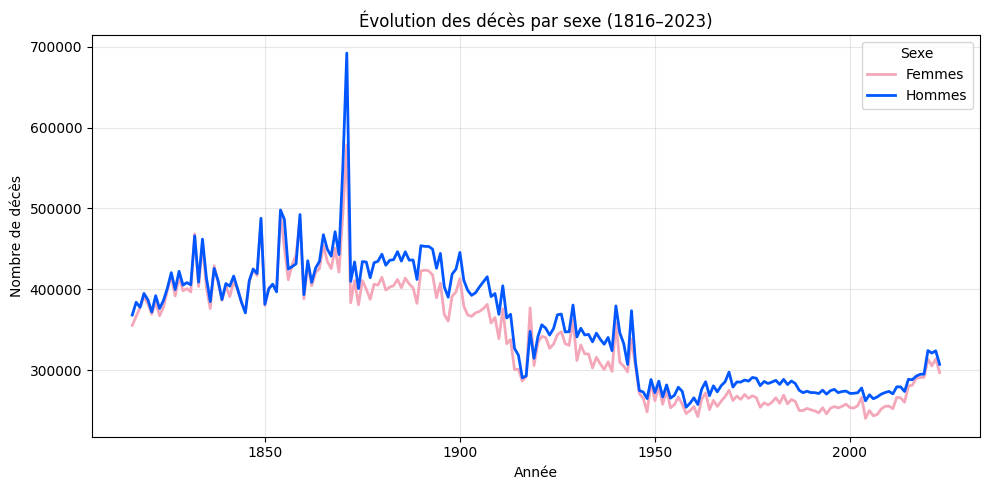

In [201]:

YEAR_COL = "Year"

# Somme annuelle des décès par sexe
dec = dfm.groupby(YEAR_COL)[["D_F", "D_M"]].sum().sort_index()

plt.figure(figsize=(10,5))

# Femmes en rose
plt.plot(dec.index, dec["D_F"], 
         label="Femmes", 
         linewidth=2, 
         color="#F4A7B9")   # rose clair

# Hommes en bleu
plt.plot(dec.index, dec["D_M"], 
         label="Hommes", 
         linewidth=2, 
         color="#0057FF")   # bleu vif

plt.title("Évolution des décès par sexe (1816–2023)")
plt.xlabel("Année")
plt.ylabel("Nombre de décès")
plt.grid(True, alpha=0.3)
plt.legend(title="Sexe")
plt.tight_layout()
plt.show()


**Interprétation :**  
Le graphique montre l’évolution du **nombre annuel de décès** pour les **femmes** (rose) et les **hommes** (bleu). Sur toute la période, la courbe des hommes reste au-dessus de celle des femmes : les décès masculins sont donc presque toujours plus nombreux, ce qui reflète une mortalité plus élevée chez les hommes.

On observe une **tendance globale à la baisse** des décès au fil du temps, grâce à l’amélioration des conditions de vie et du système de santé. À partir de la seconde moitié du XXᵉ siècle, les décès se stabilisent puis remontent légèrement, ce qui peut être lié au **vieillissement de la population** et à quelques épisodes de surmortalité récente.

Un **pic très marqué** apparaît autour des années **1870** : il correspond à la **guerre franco-prussienne (1870–1871)** et aux **crises sanitaires** qui l’accompagnent (épidémies, mauvaises conditions de vie), ce qui provoque une surmortalité exceptionnelle. D’autres pics plus courts apparaissent plus tard (Première et Seconde Guerres mondiales, pandémie de Covid-19), mais d’ampleur relative moindre que celui de 1870 sur ce graphique.


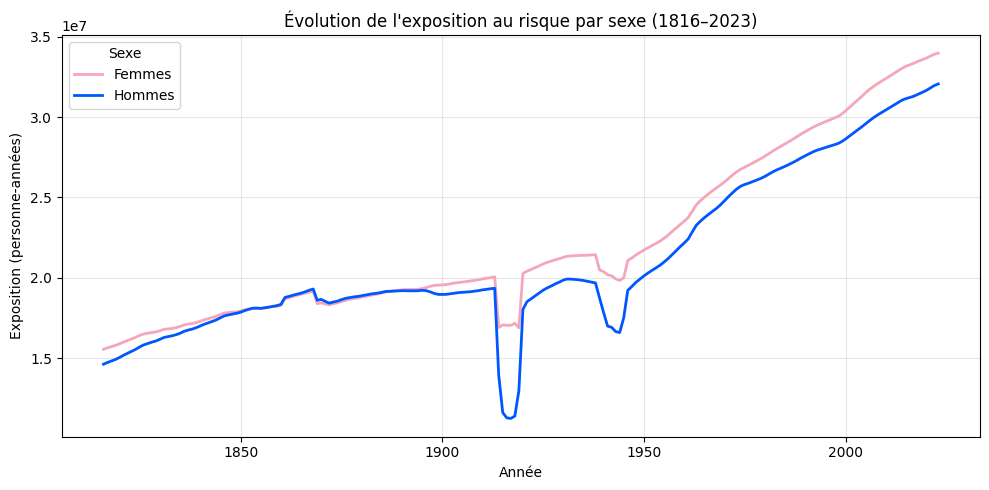

In [202]:

YEAR_COL = "Year"  

# Somme annuelle des expositions par sexe
expo = dfm.groupby(YEAR_COL)[["E_F", "E_M"]].sum().sort_index()

plt.figure(figsize=(10,5))

# Femmes en rose
plt.plot(expo.index, expo["E_F"],
         label="Femmes",
         linewidth=2,
         color="#F4A7B9")

# Hommes en bleu
plt.plot(expo.index, expo["E_M"],
         label="Hommes",
         linewidth=2,
         color="#0057FF")

plt.title("Évolution de l'exposition au risque par sexe (1816–2023)")
plt.xlabel("Année")
plt.ylabel("Exposition (personne-années)")
plt.grid(True, alpha=0.3)
plt.legend(title="Sexe")
plt.tight_layout()
plt.show()


**Interprétation :**  
Le graphique représente l’évolution de l’**exposition au risque de décès** (en personne-années) pour les **femmes** et les **hommes** entre 1816 et 2023. Globalement, les deux courbes sont croissantes : la population française exposée augmente fortement au fil du temps, ce qui reflète la **croissance démographique** et l’allongement de la durée de vie. La courbe des femmes est presque toujours légèrement au-dessus de celle des hommes, en cohérence avec une population féminine un peu plus nombreuse, surtout aux âges élevés.

On observe toutefois des **ruptures nettes** : une chute très marquée autour de la **Première Guerre mondiale (1914-1918)**, beaucoup plus prononcée pour les hommes, puis une nouvelle baisse autour de la **Seconde Guerre mondiale**. Ces épisodes traduisent à la fois les pertes humaines directes et les effets de crise sur la structure par âge de la population. Après 1945, l’exposition repart à la hausse de façon soutenue, portée par la croissance d’après-guerre et le **vieillissement progressif** de la population, jusqu’aux niveaux très élevés observés en fin de période.


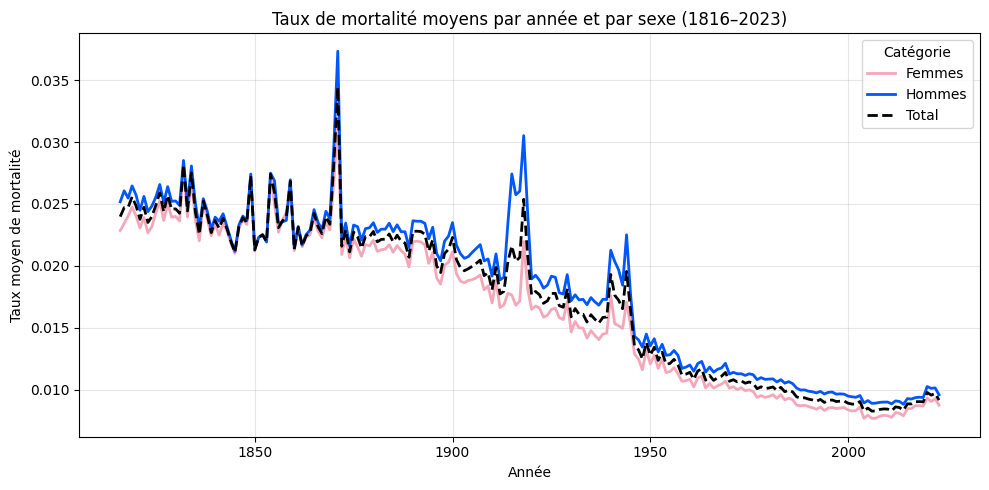

In [203]:

YEAR_COL = "Year" 

# Agrégation annuelle (ratio des sommes)
grp = dfm.groupby(YEAR_COL).agg({
    "D_F": "sum", "E_F": "sum",
    "D_M": "sum", "E_M": "sum"
}).sort_index()

mF = grp["D_F"] / grp["E_F"]
mH = grp["D_M"] / grp["E_M"]
mT = (grp["D_F"] + grp["D_M"]) / (grp["E_F"] + grp["E_M"])

plt.figure(figsize=(10,5))

# Femmes en rose
plt.plot(mF.index, mF.values,
         label="Femmes",
         linewidth=2,
         color="#F4A7B9")

# Hommes en bleu
plt.plot(mH.index, mH.values,
         label="Hommes",
         linewidth=2,
         color="#0057FF")

# Total en noir pointillé
plt.plot(mT.index, mT.values,
         label="Total",
         linewidth=2,
         color="#000000",
         linestyle="--")

plt.title("Taux de mortalité moyens par année et par sexe (1816–2023)")
plt.xlabel("Année")
plt.ylabel("Taux moyen de mortalité")
plt.grid(True, alpha=0.3)
plt.legend(title="Catégorie")
plt.tight_layout()
plt.show()

**Interprétation :**  
Le graphique présente l’évolution des **taux de mortalité moyens** entre 1816 et 2023 pour les femmes (rose), les hommes (bleu) et l’ensemble de la population (pointillé noir). On voit clairement une **tendance de fond à la baisse** : les taux passent d’environ 2,5 % au XIXᵉ siècle à moins de 1 % à la fin de la période, ce qui reflète les progrès médicaux, sanitaires et sociaux.

À presque toutes les dates, le taux des **hommes** reste au-dessus de celui des **femmes**, et le taux **total** se situe entre les deux. Cela confirme une mortalité masculine plus élevée sur longue période.

Plusieurs **pics** rompent cette tendance : un pic important autour des années **1870** (guerre franco-prussienne et crises sanitaires), puis d’autres hausses marquées au moment des **deux guerres mondiales**. On note enfin une légère remontée des taux à la toute fin de la série, que l’on peut relier aux épisodes récents de **surdécès**, notamment la pandémie de Covid-19.


### 3 - Profil de mortalité par age :

L’analyse du profil de mortalité en fonction de l’âge permet de mieux comprendre les dynamiques démographiques sous-jacentes. En effet, le taux de mortalité *m(x)* varie considérablement selon l’âge, et sa forme est révélatrice des structures sanitaires et sociales d’une population.

Nous étudions ici les **courbes de mortalité par âge** pour les années **1816, 1920 et 2023**, en distinguant **hommes** et **femmes**.  
Ces profils sont tracés sur une **échelle logarithmique**, conformément aux pratiques actuarielles, afin de mieux visualiser les écarts sur plusieurs ordres de grandeur.


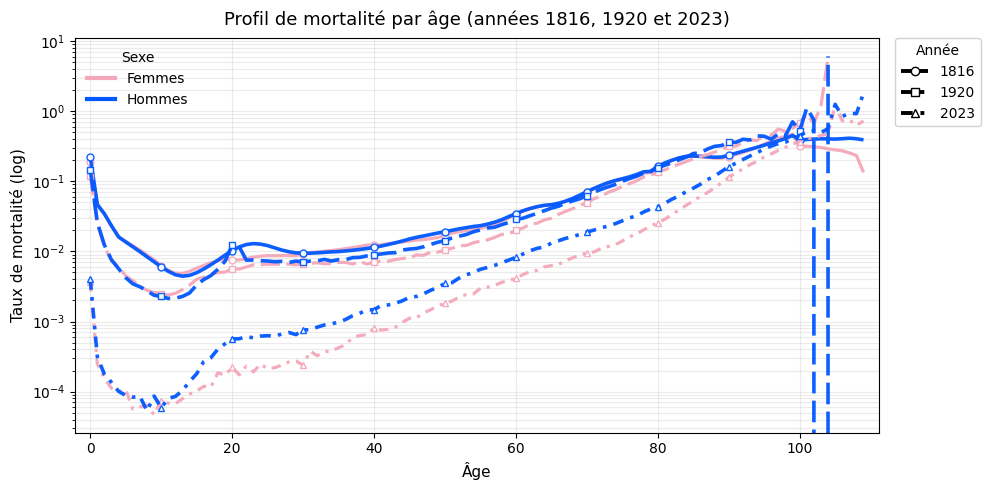

In [204]:
YEAR_COL = "Year"
AGE_COL  = "Age"

# Couleurs sexe
color_f, color_h = "#F4A7B9", "#0057FF"

# Styles années (traits TRÈS distincts) + marqueurs
dash = {
    1816: (0, (1, 0)),           # plein
    1920: (0, (6, 2)),           # tirets longs
    2023: (0, (3, 2, 1, 2)),     # tirets-points
}
markers = {1816: "o", 1920: "s", 2023: "^"}

years = [1816, 1920, 2023]

# Calcul m_F/m_H si besoin
if "m_F" not in df.columns and {"D_F","E_F"}.issubset(dfm.columns):
    df["m_F"] = df["D_F"] / df["E_F"]
if "m_M" not in df.columns and {"D_M","E_M"}.issubset(dfm.columns):
    df["m_M"] = df["D_M"] / df["E_M"]

sub = df[df[YEAR_COL].isin(years)].dropna(subset=[AGE_COL, "m_F", "m_M"]).copy()

fig, ax = plt.subplots(figsize=(10,5))

# Courbes par année + sexe (mêmes couleurs; styles/markers par année)
for y in years:
    d = sub[sub[YEAR_COL] == y].sort_values(AGE_COL)
    # Femmes
    ax.plot(
        d[AGE_COL], d["m_F"],
        color=color_f, linestyle=dash[y], linewidth=2.3, alpha=0.95,
        marker=markers[y], markevery=10, markersize=5, markerfacecolor="white"
    )
    # Hommes
    ax.plot(
        d[AGE_COL], d["m_M"],
        color=color_h, linestyle=dash[y], linewidth=2.6, alpha=0.95,
        marker=markers[y], markevery=10, markersize=5, markerfacecolor="white"
    )

# Mise en forme
ax.set_yscale("log")
ax.grid(True, which="both", alpha=0.25)
ax.set_xlabel("Âge", fontsize=11)
ax.set_ylabel("Taux de mortalité (log)", fontsize=11)
ax.set_title("Profil de mortalité par âge (années 1816, 1920 et 2023)", fontsize=13, pad=10)
ax.tick_params(axis="both", labelsize=10)
ax.margins(x=0.02, y=0.05)

# Légende SEXE (couleurs)
sex_handles = [
    Line2D([0],[0], color=color_f, lw=3, label="Femmes"),
    Line2D([0],[0], color=color_h, lw=3, label="Hommes"),
]
leg1 = ax.legend(
    handles=sex_handles, title="Sexe",
    loc="upper left", frameon=False
)
ax.add_artist(leg1)

# Légende ANNÉE (traits + marqueurs clairs, à droite, encadré)
year_handles = [
    Line2D([0],[0],
           color="black", lw=2.8, linestyle=dash[y],
           marker=markers[y], markersize=6, markerfacecolor="white",
           label=str(y))
    for y in years
]
leg2 = ax.legend(
    handles=year_handles, title="Année",
    loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0,
    frameon=True, fancybox=True
)
leg2.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()


**Interprétation :**  
Le graphique représente les **taux de mortalité par âge** (en échelle logarithmique) pour trois années : **1816**, **1920** et **2023**, séparément pour les femmes (rose) et les hommes (bleu). On retrouve la forme classique en U de la mortalité :  
- très forte mortalité à la naissance,  
- chute rapide jusqu’à l’adolescence,  
- puis augmentation régulière avec l’âge à partir de l’âge adulte.  

Pour presque tous les âges, les **courbes de 2023** sont nettement **en dessous** de celles de 1816 et 1920 : la mortalité a donc fortement diminué, surtout aux jeunes et moyens âges. L’année **1920** présente des niveaux de mortalité plus élevés, ce qui reflète encore l’effet de la **Première Guerre mondiale** et de la **grippe espagnole**. À âge donné, les taux des **hommes** restent généralement au-dessus de ceux des **femmes**, ce qui confirme une mortalité masculine plus forte.

Aux très grands âges, les courbes deviennent plus irrégulières (fortes oscillations), ce qui traduit la **faible taille des effectifs** et la plus grande instabilité des taux de mortalité observés dans ces classes d’âge extrêmes.

### 4 - Analyse croisée age-année :

Au-delà des profils par âge ou par année, une représentation conjointe des deux dimensions permet de mieux saisir les dynamiques croisées de la mortalité. La carte thermique suivante illustre l’évolution du taux de mortalité agrégé **m(t, x)**, selon l’âge (ordonnée) et l’année (abscisse). Ce type de visualisation est particulièrement utile pour repérer des discontinuités ou des ruptures dans le temps, notamment celles liées à des chocs sanitaires.


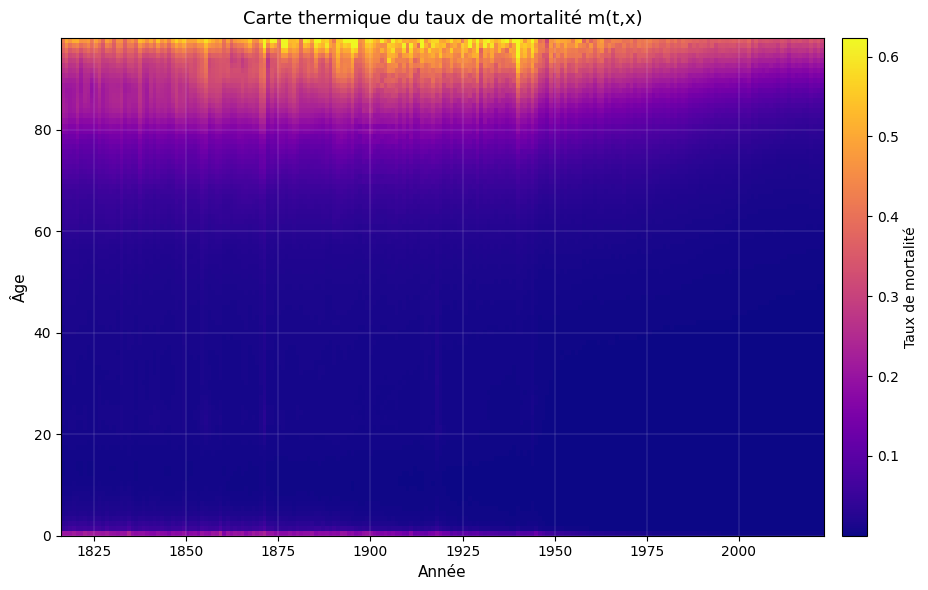

In [205]:


# === 1) Paramètres colonnes ===============================
YEAR_COL = "Year"     # année
AGE_COL  = "Age"      # âge
D_F_COL, D_H_COL = "D_F", "D_M"
E_F_COL, E_H_COL = "E_F", "E_M"
M_TOT_COL = "m_Tot"   # si présent, on l'utilise directement

# === 2) Calcul du taux m(t,x) agrégé par âge & année ========================
df_cal = dfm.copy()

# Si m_Tot absent, on le calcule (ratio des D totaux sur E totales)
if M_TOT_COL not in df_cal.columns:
    if {D_F_COL, D_H_COL, E_F_COL, E_H_COL}.issubset(df_cal.columns):
        df_cal["D_Tot"] = df_cal[D_F_COL].astype(float) + df_cal[D_H_COL].astype(float)
        df_cal["E_Tot"] = df_cal[E_F_COL].astype(float) + df_cal[E_H_COL].astype(float)
        # éviter division par 0
        df_cal.loc[df_cal["E_Tot"] <= 0, "E_Tot"] = np.nan
        df_cal["m_Tot"] = df_cal["D_Tot"] / df_cal["E_Tot"]
    else:
        raise ValueError("Colonne m_Tot absente et colonnes D_/E_ manquantes pour le calcul.")

# On garde uniquement les colonnes utiles et lignes valides
z = df_cal[[YEAR_COL, AGE_COL, "m_Tot"]].dropna()

# Option : tronquer à des bornes raisonnables pour l’échelle des couleurs
z["m_Tot"] = z["m_Tot"].clip(lower=0, upper=z["m_Tot"].quantile(0.999))

# === 3) Mise en grille (pivot : lignes=Âge, colonnes=Année) ==================
mat = z.pivot_table(index=AGE_COL, columns=YEAR_COL, values="m_Tot", aggfunc="mean")
mat = mat.sort_index(axis=0).sort_index(axis=1)  # trier âge et année

ages  = mat.index.values
years = mat.columns.values
data  = mat.values

# === 4) Tracé de la heatmap =================================
fig, ax = plt.subplots(figsize=(10, 6))

# extent pour des axes en vraies unités (années/âges)
extent = [years.min(), years.max(), ages.min(), ages.max()]

# colormap 
im = ax.imshow(
    data,
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="plasma",
    interpolation="nearest",   # blocs nets; mets "bilinear" si tu veux lissage
    norm=Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
)

# Axes et titres 
ax.set_title("Carte thermique du taux de mortalité m(t,x)", fontsize=13, pad=10)
ax.set_xlabel("Année", fontsize=11)
ax.set_ylabel("Âge", fontsize=11)

# Grille légère pour la lisibilité
ax.grid(color="white", linestyle="-", linewidth=0.2, alpha=0.6)

# Barre de couleurs
cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("Taux de mortalité", fontsize=10)

# Ajustements
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()


**Interprétation :**  
Cette carte thermique représente l’évolution du **taux de mortalité** en fonction de l’**âge** (axe vertical) et de l’**année** (axe horizontal). Les couleurs foncées indiquent des taux faibles, les couleurs claires des taux élevés.

On observe d’abord que les couleurs sont **très claires aux grands âges** (au-dessus de 70–80 ans) et beaucoup plus **sombres aux jeunes âges** : la mortalité reste donc fortement croissante avec l’âge, quel que soit le calendrier.

Ensuite, pour un âge donné, les couleurs deviennent globalement **plus sombres quand on se déplace vers les années récentes**, ce qui traduit la **baisse de la mortalité au cours du temps** : à âge identique, on meurt moins aujourd’hui qu’au XIXᵉ siècle.

On distingue aussi quelques **bandes verticales plus claires** (pics de mortalité) qui correspondent à des périodes de crise – guerres, épidémies – mais elles restent localisées dans le temps. Globalement, la carte confirme donc deux faits majeurs :  
1) une mortalité très forte aux âges élevés ;  
2) une amélioration nette et progressive de la mortalité sur l’ensemble de la période étudiée.

### 5 - Comparaison Hommes-Femmes :

L’un des phénomènes structurels les plus bien documentés en démographie est la **surmortalité masculine**, observée à presque tous les âges.  
Pour mieux quantifier cette inégalité, nous analysons ici deux indicateurs comparatifs :

- La différence Δm(x) = *mₕ(x)* − *m𝒻(x)*, calculée pour chaque âge puis moyennée sur toutes les années ;
- Le ratio *mₕ(t, x)* / *m𝒻(t, x)*, observé simultanément par âge et année, et représenté sous forme de **carte thermique**.


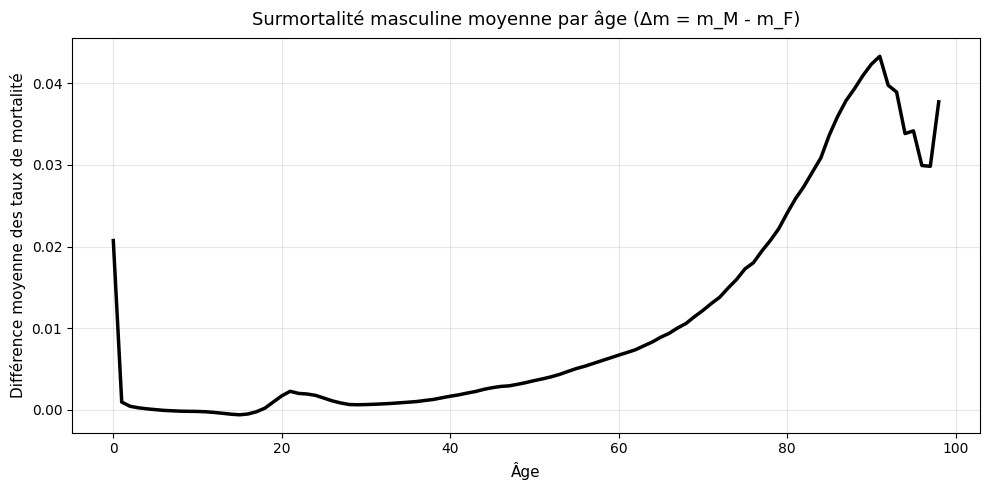

In [206]:
AGE_COL = "Age" 

# 1) Moyenne des taux par âge (toutes années confondues)
by_age = (
    dfm
    .groupby(AGE_COL)[["m_M", "m_F"]]
    .mean()
    .sort_index()
)

# 2) Surmortalité masculine Δm(x) = m_H - m_F
by_age["Delta_m"] = by_age["m_M"] - by_age["m_F"]

# 3) Tracé
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    by_age.index,
    by_age["Delta_m"],
    color="black",          # courbe noire
    linewidth=2.5
)

ax.set_title("Surmortalité masculine moyenne par âge (Δm = m_M - m_F)", fontsize=13, pad=10)
ax.set_xlabel("Âge", fontsize=11)
ax.set_ylabel("Différence moyenne des taux de mortalité", fontsize=11)

ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

**Interprétation :**  
Ce graphique montre, pour chaque âge, la **différence moyenne des taux de mortalité** entre hommes et femmes  m_M - m_F . Une valeur positive signifie que les hommes meurent plus que les femmes à cet âge.

On voit d’abord une **surmortalité masculine très forte à la naissance** (autour de 0,02), qui chute rapidement et devient presque nulle pendant l’enfance. À partir de la fin de l’adolescence et surtout à l’âge adulte, la courbe remonte progressivement : les hommes présentent alors un risque de décès légèrement supérieur, lié notamment aux comportements plus risqués et à certaines pathologies.

À partir d’environ **50–60 ans**, la surmortalité masculine augmente fortement et atteint un maximum autour de **80–90 ans** (près de 0,04). Cela signifie qu’aux âges élevés, les hommes ont une **probabilité de décès nettement plus forte** que les femmes, ce qui est cohérent avec la meilleure longévité féminine observée en France.

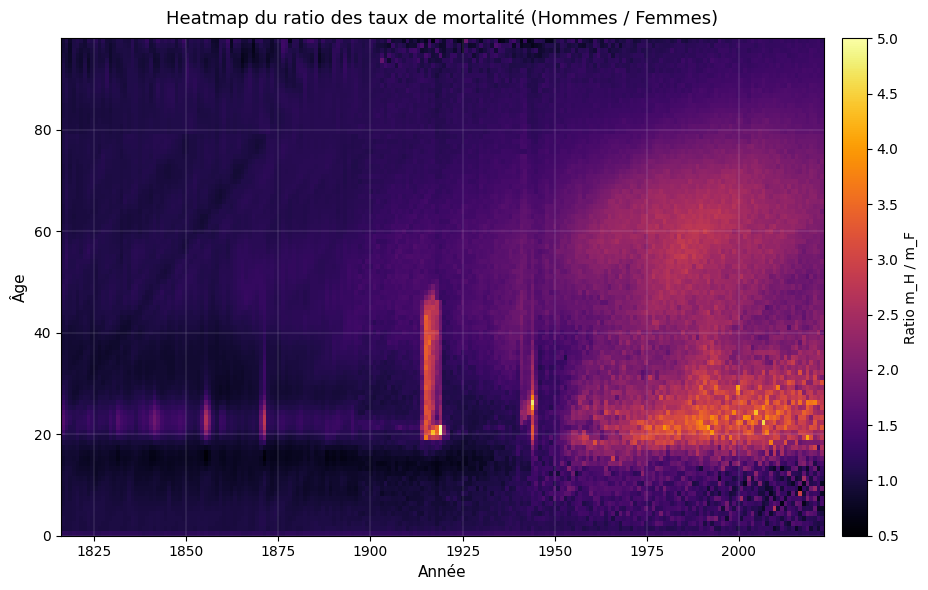

In [207]:

# === 1) Noms de colonnes (adapte si besoin) ===============================
YEAR_COL = "Year"
AGE_COL  = "Age"

# === 2) Calcul du ratio m_H / m_F ========================================
df_ratio = dfm.copy()

# éviter division par zéro : on met NaN quand m_F <= 0
df_ratio.loc[df_ratio["m_F"] <= 0, "m_F"] = np.nan
df_ratio["ratio_HF"] = df_ratio["m_M"] / df_ratio["m_F"]

# on enlève les lignes sans ratio valide
z = df_ratio[[YEAR_COL, AGE_COL, "ratio_HF"]].dropna()

# option : tronquer les valeurs extrêmes pour une échelle de couleur lisible
z["ratio_HF"] = z["ratio_HF"].clip(lower=0.5, upper=5)

# === 3) Mise en grille : lignes = Âge, colonnes = Année ==================
mat = z.pivot_table(
    index=AGE_COL,
    columns=YEAR_COL,
    values="ratio_HF",
    aggfunc="mean"
).sort_index(axis=0).sort_index(axis=1)

ages  = mat.index.values
years = mat.columns.values
data  = mat.values

# === 4) Tracé de la heatmap =============================================
fig, ax = plt.subplots(figsize=(10, 6))

extent = [years.min(), years.max(), ages.min(), ages.max()]

im = ax.imshow(
    data,
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="inferno",  # violet -> jaune, proche de ton exemple
    interpolation="nearest",
    norm=Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
)

ax.set_title("Heatmap du ratio des taux de mortalité (Hommes / Femmes)", fontsize=13, pad=10)
ax.set_xlabel("Année", fontsize=11)
ax.set_ylabel("Âge", fontsize=11)

ax.grid(color="white", linestyle="-", linewidth=0.2, alpha=0.6)

# Barre de couleurs
cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("Ratio m_H / m_F", fontsize=10)

ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()


**Interprétation :**  
Cette carte thermique représente, pour chaque couple *(année, âge)*, le **ratio des taux de mortalité** \(m_H / m_F\).  
- Des couleurs proches du violet indiquent un ratio proche de **1** (mortalité similaire entre hommes et femmes).  
- Des zones jaune/orange correspondent à des ratios **supérieurs à 2 ou 3**, donc à une forte **surmortalité masculine**.

On observe d’abord que la surmortalité masculine est particulièrement marquée autour des **âges jeunes adultes** (environ 20–30 ans), surtout au XXᵉ siècle : les zones les plus claires se concentrent aux alentours de **1914–1920** et **1939–1945**, ce qui renvoie aux **deux guerres mondiales** où les hommes jeunes ont été beaucoup plus touchés que les femmes. Après 1960, on voit aussi une bande claire et plus diffuse chez les 20–30 ans, qui reflète les différences de comportements (accidents, conduites à risque, etc.).

Aux **âges élevés**, les couleurs restent plus proches du violet ou du jaune pâle : la mortalité masculine y reste supérieure à la féminine, mais de façon moins extrême que chez les jeunes adultes. Globalement, la heatmap confirme donc que la **surmortalité masculine** est surtout forte à certains âges et dans des périodes de crise, alors qu’elle est plus modérée mais persistante aux grands âges.


### 6 - Synthèse descriptive générale :

L’analyse descriptive menée dans cette première partie a permis de dresser un portrait statistique complet de la mortalité dans la population française entre 2000 et 2022. Plusieurs enseignements majeurs peuvent être retenus :

- **Structure globale :**  
  Les taux de mortalité présentent une distribution très asymétrique selon l’âge, avec des valeurs extrêmement faibles chez les jeunes et une croissance rapide après 60 ans. Les statistiques descriptives ont confirmé l’ordre de grandeur des variables d’exposition, des décès et des mortalités, ainsi que leur dispersion.

- **Évolution temporelle :**  
  L’analyse des séries chronologiques a révélé une tendance générale à la baisse des taux de mortalité moyens au cours des deux dernières décennies, avec une rupture nette en 2020–2021 liée à l’effet COVID-19. Les expositions sont en hausse continue, traduisant l’allongement de la durée de vie.

- **Profil par âge :**  
  Le profil de mortalité par âge suit une forme en “U” inversé logarithmique, typique des modèles actuarielles : mortalité élevée à la naissance, plateau minimal aux âges scolaires, puis croissance exponentielle aux grands âges.

- **Comparaisons hommes / femmes :**  
  La surmortalité masculine est structurelle, présente à tous les âges, avec un différentiel maximal autour de 20 à 40 ans (ratios supérieurs à 3). La différence \( m_H - m_F \) devient très significative au-delà de 70 ans.


L’ensemble des résultats obtenus dans la partie descriptive fournit un socle empirique solide pour aborder la phase de modélisation.  
Les analyses menées ont permis d’identifier les caractéristiques essentielles de la mortalité au sein de la population étudiée :

- une structure fortement dépendante de l’âge, avec une dynamique exponentielle aux grands âges ;
- des différences marquées entre hommes et femmes, révélatrices de comportements et facteurs biologiques différenciés ;
- des ruptures temporelles significatives, notamment autour de 2020–2021 en lien avec la pandémie ;
- des zones d’instabilité statistique identifiées via le coefficient de variation ;
- une corrélation nette et robuste entre âge et taux de mortalité total.

Ces constats confirment la nécessité d’utiliser des **modèles paramétriques ou semi-paramétriques** intégrant explicitement l’âge et, éventuellement, le temps, afin de capturer correctement les tendances observées.  

Dans la section suivante, nous présentons les principaux modèles de projection utilisés en démographie et en actuariat — notamment le **modèle de Lee–Carter**, ainsi que des approches issues de l’apprentissage automatique — et nous évaluons leur capacité à reproduire et anticiper les profils de mortalité observés.


## II) Modèle de Lee-Carter


Dans le domaine de la démographie actuarielle, la modélisation des taux de mortalité constitue un enjeu central, tant pour les projections démographiques à long terme que pour la valorisation des engagements liés aux retraites, à l’assurance-vie ou à la santé.

Parmi les nombreuses approches proposées, le **modèle de Lee–Carter (1992)** s’est imposé comme une référence incontournable. Il combine :

- une décomposition **log-linéaire** de la mortalité selon l’âge et le temps,
- une grande **simplicité de mise en œuvre**,
- une **capacité satisfaisante de projection**.

---

Dans cette section, nous mettons en œuvre le modèle de Lee–Carter sur notre base de données, en suivant les étapes classiques d’estimation :

1. **Transformation logarithmique des taux de mortalité**,  
2. **Décomposition matricielle par valeurs singulières (SVD)**,  
3. **Visualisation des composantes** (effet âge, effet temps),  
4. **Extrapolation de la dynamique temporelle**,  
5. **Comparaison entre taux observés et taux prédits**.

---

L’objectif est double :

- **Évaluer la qualité d’ajustement** du modèle aux données historiques.
- **Fournir une base de référence** pour comparer les performances des méthodes d’apprentissage automatique dans la section suivante.

### 1) Formulation mathématique du modèle de Lee–Carter

Le modèle de Lee–Carter repose sur l’hypothèse que le **logarithme du taux de mortalité** à l’âge \(x\) et à l’année \(t\) peut s’exprimer comme une combinaison linéaire de trois composantes principales :


**ln m_{x,t} = alpha_x + (beta_x . kappa_t) + epsilon_{x,t}**


où :

- **alpha_x** : profil moyen de mortalité selon l’âge.  
  Il représente le niveau moyen (sur la période) du log-taux de mortalité pour chaque âge.

- **kappa_t** : indice synthétique résumant l’évolution globale de la mortalité dans le temps.  
  Une baisse de kappa_t correspond à un recul général de la mortalité.

- **beta_x** : sensibilité de la mortalité à l’âge \(x\) aux variations de kappa_t.  
  Les âges pour lesquels \(\beta_x\) est élevé réagissent davantage aux améliorations ou dégradations de la mortalité.

- **epsilon_{x,t}** : terme d’erreur aléatoire supposé centré.

---

#### Hypothèse structurante

Le modèle impose une **structure multiplicative log-linéaire** entre les effets d’âge et les effets temporels.  
Cette propriété le rend particulièrement adapté aux données longitudinales en mortalité.

---

#### Estimation par décomposition SVD

L’estimation du triplet (alpha_x, beta_x, kappa_t) repose sur une **décomposition en valeurs singulières (SVD)** appliquée aux log-taux de mortalité centrés.

Comme la décomposition n’est pas unique, deux contraintes d’identifiabilité standard sont imposées : **la somme des kappa_t doit valoir 0 et la somme des beta_x doit valoir 1.**

Ces contraintes assurent une solution **unique, stable et interprétable**.

---

Dans la suite, nous appliquons pas à pas cet algorithme d’estimation à partir de notre base de données consolidée.


### 2) Etapes de calibration du modèle 

L’estimation du modèle de Lee–Carter est réalisée sur les données de mortalité de 1816 à 1869, afin de permettre une validation hors-échantillon sur les années 1969–2023.  
Le modèle est ajusté séparément pour trois sous-populations : **femmes**, **hommes** et **population totale**.

In [208]:
# on sépare train et test 
train_years = range(1816, 1969)  # 1816-1996 pour l'entraînement
test_years = range(1970, 2023)   # 1997-2023 pour le test

# on crée les deux bases
dfm_train = dfm[dfm['Year'].isin(train_years)].copy()
dfm_test = dfm[dfm['Year'].isin(test_years)].copy()

Pour chaque groupe, les étapes suivantes sont appliquées :

#### 1. Transformation logarithmique
Pour chaque âge x et année t, on calcule ln(m(x,t)), où m(x,t) est le taux de mortalité observé.


In [209]:
# Etape 1  : transformation logarithmique pour chaque genre
dfm_train['ln_m_F'] = np.log(dfm_train['m_F'])
dfm_train['ln_m_M'] = np.log(dfm_train['m_M'])
dfm_train['ln_m_Tot'] = np.log(dfm_train['m_Tot'])

#### 2. Organisation matricielle 
Création d'une matrice M avec :
- lignes = âges,
- colonnes = années,
- valeurs = ln(m(x,t)).

In [210]:
# Étape 2 : Organisation matricielle pour chaque sexe (âges en lignes, années en colonnes)

# Pour les Femmes
M_F_train = dfm_train.pivot(index='Age', columns='Year', values='ln_m_F')

# Pour les Hommes  
M_M_train = dfm_train.pivot(index='Age', columns='Year', values='ln_m_M')

# Pour le Total
M_Tot_train = dfm_train.pivot(index='Age', columns='Year', values='ln_m_Tot')

#### 3. Calcul du profil moyen par âge (alpha_x)
Pour chaque âge x :
- alpha_x = moyenne des ln(m(x,t)) sur toutes les années.

In [211]:
# Étape 3 : Profil moyen par âge α_x = moyenne des log-taux sur toutes les années pour chaque âge

# Pour les Femmes
alpha_F_train = M_F_train.mean(axis=1)  # Moyenne sur les colonnes (années)

# Pour les Hommes
alpha_M_train = M_M_train.mean(axis=1)

# Pour le Total
alpha_Tot_train = M_Tot_train.mean(axis=1)

#### 4. Centrage des données
Pour obtenir une matrice centrée Z :
- Z(x,t) = ln(m(x,t)) − alpha(x).

In [212]:
# Étape 4 : Centrage de la matrice Z_x,t = ln(m_x,t) - α_x
# On soustrait le profil moyen α_x de chaque ligne

# Pour les Femmes
Z_F_train = M_F_train.sub(alpha_F_train, axis=0)  # Soustraction ligne par ligne

# Pour les Hommes
Z_M_train = M_M_train.sub(alpha_M_train, axis=0)

# Pour le Total
Z_Tot_train = M_Tot_train.sub(alpha_Tot_train, axis=0)

#### 5. Décomposition en valeurs singulières (SVD)
Application de la SVD :
- Z = U × Sigma × Vᵀ.
Avec : 
- U : matrice des vecteurs singuliers gauches (dimension âges)
- Sigma : vecteur des valeurs singulières (classées par ordre décroissant)
- Vᵀ : matrice des vecteurs singuliers droits transposée (dimension temps)

In [213]:
# Étape 5 : Décomposition en valeurs singulières (SVD) Z = U · Σ · V^T

# Pour les Femmes
U_F_train, Sigma_F_train, VT_F_train = np.linalg.svd(Z_F_train, full_matrices=False)

# Pour les Hommes
U_M_train, Sigma_M_train, VT_M_train = np.linalg.svd(Z_M_train, full_matrices=False)

# Pour le Total
U_Tot_train, Sigma_Tot_train, VT_Tot_train = np.linalg.svd(Z_Tot_train, full_matrices=False)


#### 6. Extraction des composantes principales
On retient :
- beta(x) = première colonne de U,
- kappa(t) = première colonne de V multipliée par la première valeur singulière.

Interprétation :
- beta(x) décrit la sensibilité de chaque âge aux variations temporelles,
- kappa(t) représente l’évolution temporelle globale de la mortalité.

In [214]:
# Étape 6 : Extraction des composantes principales
# β_x = première colonne de U (u_1)
# κ_t = σ_1 · première ligne de V^T (v_1)

# Pour les Femmes
beta_F_train = U_F_train[:, 0]  # Première colonne de U
kappa_F_train = Sigma_F_train[0] * VT_F_train[0, :]  # σ_1 * première ligne de V^T

# Pour les Hommes
beta_M_train = U_M_train[:, 0]
kappa_M_train = Sigma_M_train[0] * VT_M_train[0, :]

# Pour le Total
beta_Tot_train = U_Tot_train[:, 0]
kappa_Tot_train = Sigma_Tot_train[0] * VT_Tot_train[0, :]



#### 7. Contraintes d’identifiabilité
Pour garantir une décomposition unique :
- la somme des beta(x) est fixée à 1,
- la somme des kappa(t) est fixée à 0.

Ces étapes permettent d’obtenir une estimation cohérente et interprétable des composantes du modèle de Lee–Carter pour chaque sous-population.

In [215]:
# Étape 7 : Contraintes d'identifiabilité
# Contrainte 1 : on normalise beta pour que somme des β_x = 1 
# Contrainte 2 : on ajuste kappa pour que somme des κ_t = 0

# Pour les Femmes
beta_F_train = beta_F_train / beta_F_train.sum()
kappa_F_train = kappa_F_train - kappa_F_train.mean()

# Pour les Hommes
beta_M_train = beta_M_train / beta_M_train.sum()
kappa_M_train = kappa_M_train - kappa_M_train.mean()

# Pour le Total
beta_Tot_train = beta_Tot_train / beta_Tot_train.sum()
kappa_Tot_train = kappa_Tot_train - kappa_Tot_train.mean()


### 2) Visualisation et interprétation des composantes du modèle

Cette section présente une analyse et une visualisation des composantes principales du modèle de **Lee–Carter**, estimées séparément pour **les femmes**, **les hommes** et **la population totale**, sur la période **1816-1969**.

Les graphiques ci-dessous permettent :

- de comparer les **profils de mortalité selon le sexe**,  
- d’analyser les **dynamiques d’évolution temporelle**,  
- et d’illustrer la manière dont chaque sous-population contribue aux variations observées des taux de mortalité.

Ces visualisations constituent une étape essentielle pour évaluer la cohérence du modèle avant la phase de projection.


#### 1) Profil moyen de log-mortalité par âge (alpha_x)


Le tracé du profil **alpha_x** met en évidence une structure de mortalité classique en actuariat :

- une mortalité **élevée à la naissance** (âge 0), suivie d’un **creux marqué** aux âges jeunes (environ 5–15 ans),  
- une **croissance lente mais régulière** à partir de 30 ans,  
- puis une **accélération rapide** après 60 ans.

On observe également que :

- la courbe des **hommes** est systématiquement **au-dessus** de celle des femmes, traduisant une mortalité masculine historiquement plus élevée à tous les âges 
- la courbe **agrégée (total)** se situe logiquement **entre les deux**, reflétant la composition démographique globale.


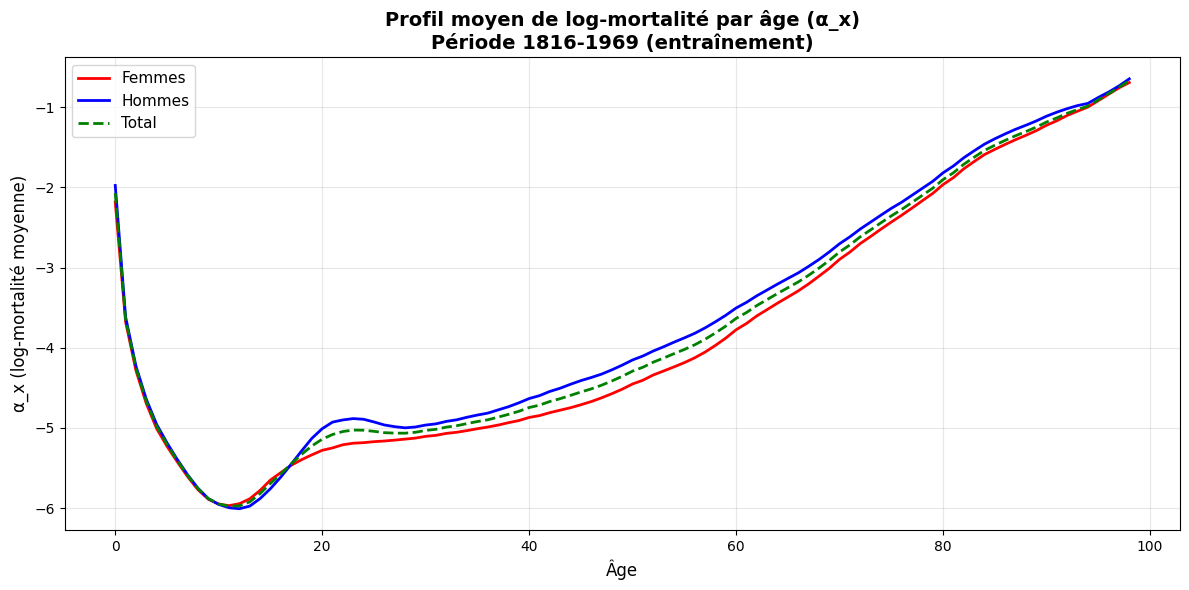

Statistiques sur apha_x (train):
Femmes - Min: -5.970, Max: -0.692
Hommes - Min: -6.008, Max: -0.646
Total  - Min: -5.979, Max: -0.673


In [216]:
import matplotlib.pyplot as plt

# Figure 1 : Profil moyen de log-mortalité par âge (α_x)
# (rappel : basé sur les données d'entraînement (1816-1969)) 

plt.figure(figsize=(12, 6))

# on trace alpha_x pour les 3 populations
plt.plot(M_F_train.index, alpha_F_train, label='Femmes', linewidth=2, color='red')
plt.plot(M_M_train.index, alpha_M_train, label='Hommes', linewidth=2, color='blue')
plt.plot(M_Tot_train.index, alpha_Tot_train, label='Total', linewidth=2, color='green', linestyle='--')

plt.xlabel('Âge', fontsize=12)
plt.ylabel('α_x (log-mortalité moyenne)', fontsize=12)
plt.title('Profil moyen de log-mortalité par âge (α_x)\nPériode 1816-1969 (entraînement)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Quelques statistiques
print("Statistiques sur apha_x (train):")
print(f"Femmes - Min: {alpha_F_train.min():.3f}, Max: {alpha_F_train.max():.3f}")
print(f"Hommes - Min: {alpha_M_train.min():.3f}, Max: {alpha_M_train.max():.3f}")
print(f"Total  - Min: {alpha_Tot_train.min():.3f}, Max: {alpha_Tot_train.max():.3f}")

#### 2) Sensibilité des âges à la tendance temporelle (beta_x)

Le coefficient **beta_x** exprime la sensibilité des log-taux de mortalité à l’indice temporel **kappa_t**.  
Il nous explique à quel point chaque âge réagit aux changements globaux de mortalité
Une valeur élevée signifie que la mortalité à cet âge est fortement affectée par l’évolution globale. 
Exemple : 
- Si beta_x = 2 pour l’âge 20 ans : quand la mortalité globale baisse, la mortalité à 20 ans baisse deux fois plus vite que la moyenne.
- Si beta_x = 0.5 pour l’âge 70 ans :quand la mortalité globale baisse, la mortalité à 70 ans ne baisse que très peu
 
On observe une décroissance (avec quelques pics) suggérant que la baisse globale de mortalité a moins d'impact sur les âges très élevés. C'est assez cohérent : certains risques (maladies chroniques, vieillissement) sont moins affectés par les améliorations globales (vaccins, progrès médicaux pour les jeunes)

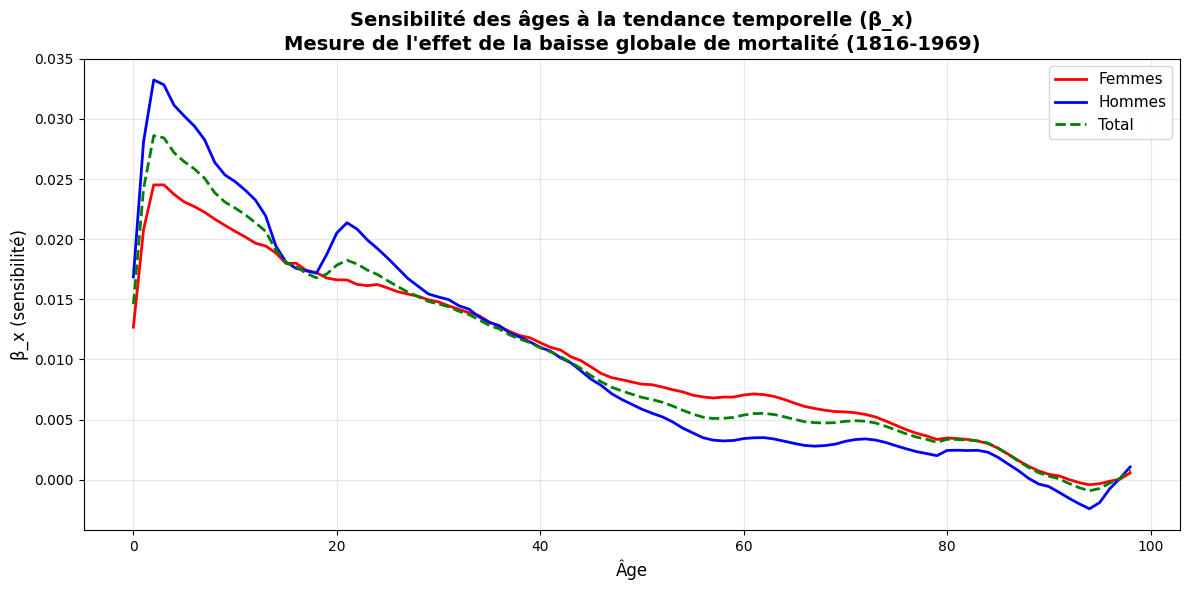

Statistiques sur beta_x (train):
Femmes - Min: -0.000424, Max: 0.024516
Hommes - Min: -0.002421, Max: 0.033236
Total  - Min: -0.000923, Max: 0.028604


In [217]:
import matplotlib.pyplot as plt

# Figure 2 : Sensibilité des âges à la tendance temporelle (β_x)
# Basé sur les données d'entraînement (1816-1996)

plt.figure(figsize=(12, 6))

# Tracer beta_x pour les 3 populations
plt.plot(M_F_train.index, beta_F_train, label='Femmes', linewidth=2, color='red')
plt.plot(M_M_train.index, beta_M_train, label='Hommes', linewidth=2, color='blue')
plt.plot(M_Tot_train.index, beta_Tot_train, label='Total', linewidth=2, color='green', linestyle='--')

plt.xlabel('Âge', fontsize=12)
plt.ylabel('β_x (sensibilité)', fontsize=12)
plt.title('Sensibilité des âges à la tendance temporelle (β_x)\nMesure de l\'effet de la baisse globale de mortalité (1816-1969)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Quelques statistiques
print("Statistiques sur beta_x (train):")
print(f"Femmes - Min: {beta_F_train.min():.6f}, Max: {beta_F_train.max():.6f}")
print(f"Hommes - Min: {beta_M_train.min():.6f}, Max: {beta_M_train.max():.6f}")
print(f"Total  - Min: {beta_Tot_train.min():.6f}, Max: {beta_Tot_train.max():.6f}")

#### 3) Evolution temporelle globale de la mortalité (kappa_t)

kappa_t reflète l’évolution générale de la mortalité au fil du temps, commune à tous les âges, mais pondérée par beta_x. Son tracé montre si, globalement, la mortalité augmente ou diminue chaque année.
On observe une décroissance globale de kappa_t : on a une tendance générale à la baisse de la mortalité. Cependant, nous avons quelques pics interessants:  
- pic vers 1870 : cela correspond à la guerre franco-prussienne (1870-1871)
- pic vers 1918 : 1ère guerre mondiale 
- pic vers 1945 : 2nd guerre mondiale 


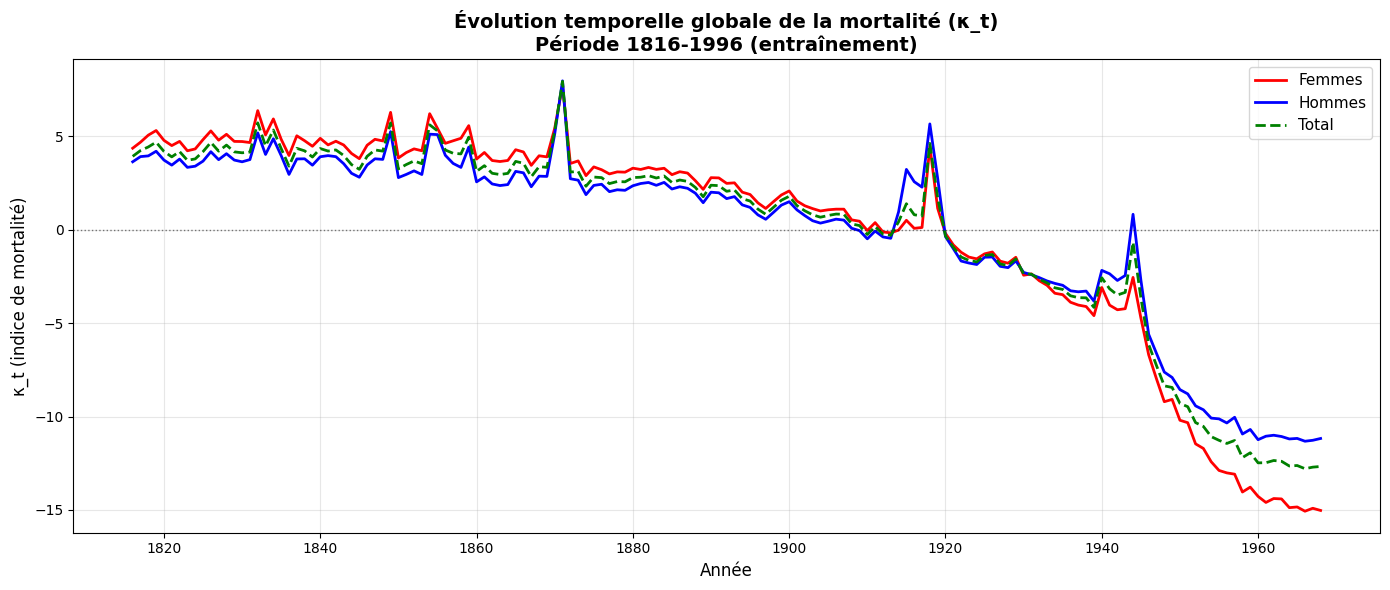

Statistiques sur κ_t (train):
Femmes - Min: -15.070, Max: 7.724
Hommes - Min: -11.323, Max: 7.973
Total  - Min: -12.794, Max: 7.947


In [218]:
import matplotlib.pyplot as plt

# Figure 3 : Évolution temporelle globale de la mortalité (κ_t)
# Basé sur les données d'entraînement (1816-1996)

plt.figure(figsize=(14, 6))

# Tracer κ_t pour les 3 populations
plt.plot(M_F_train.columns, kappa_F_train, label='Femmes', linewidth=2, color='red')
plt.plot(M_M_train.columns, kappa_M_train, label='Hommes', linewidth=2, color='blue')
plt.plot(M_Tot_train.columns, kappa_Tot_train, label='Total', linewidth=2, color='green', linestyle='--')

plt.xlabel('Année', fontsize=12)
plt.ylabel('κ_t (indice de mortalité)', fontsize=12)
plt.title('Évolution temporelle globale de la mortalité (κ_t)\nPériode 1816-1996 (entraînement)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle=':', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

# Quelques statistiques
print("Statistiques sur κ_t (train):")
print(f"Femmes - Min: {kappa_F_train.min():.3f}, Max: {kappa_F_train.max():.3f}")
print(f"Hommes - Min: {kappa_M_train.min():.3f}, Max: {kappa_M_train.max():.3f}")
print(f"Total  - Min: {kappa_Tot_train.min():.3f}, Max: {kappa_Tot_train.max():.3f}")

### 3) Analyse des résidus du modèle de Lee–Carter


Afin d’évaluer la **qualité des ajustements et des projections** obtenues par le modèle de Lee–Carter, nous avons mené une **analyse approfondie des résidus**, définis comme la différence entre les taux de mortalité observés (`m_obs`) et les taux prédits (`m_pred`).

Cette étude a été réalisée selon plusieurs axes complémentaires :

- **Visualisation** : inspection graphique des résidus pour détecter d’éventuelles anomalies ou tendances non modélisées.  
- **Distribution** : analyse statistique de la répartition des résidus pour vérifier l’hypothèse de centrage et de dispersion.  
- **Tests statistiques** : évaluation de la significativité des écarts et détection de biais éventuels.  
- **Autocorrélation** : examen des dépendances temporelles dans les résidus pour identifier d’éventuelles dynamiques non capturées par le modèle.


#### A) Etape préliminaire : Ajout des log-taux au set de test 

In [219]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore') 

In [220]:
dfm_test['ln_m_F'] = np.log(dfm_test['m_F'])
dfm_test['ln_m_M'] = np.log(dfm_test['m_M'])
dfm_test['ln_m_Tot'] = np.log(dfm_test['m_Tot'])

#### B) Projection des kappa_t avec SARIMA (1970-2023)

Pour pouvoir prédire les taux de mortalités sur la période de test 1970-2023, nous avons besoin de projeter kappa_t avec l'utilisation de series temporelles. Nous avons utiliser un SARIMA (Seasonal Autoregressive Integrated Moving Average) pour estimer l'évolution de kappa_t. 

In [221]:
# Nombre d'années à prédire
n_forecast = len(test_years) 

# Fonction pour ajuster SARIMA et projeter
def forecast_kappa_sarima(kappa_train, n_steps, 
                          order=(1,1,1),           # (p,d,q) - partie non-saisonnière
                          seasonal_order=(1,1,1,12)):  # (P,D,Q,s) - partie saisonnière
    """
    On projette kappa_t avec un modèle SARIMA
    
    Paramètres:
    -----------
    order=(p,d,q) : 
        p = ordre autorégressif (combien de valeurs passées on utilise)
        d = ordre de différenciation (pour stationnarité)
        q = ordre moyenne mobile (erreurs passées)
    
    seasonal_order=(P,D,Q,s) :
        P = AR saisonnier
        D = différenciation saisonnière
        Q = MA saisonnier
        s = période (s pour des cycles de s ans) 
    
    """
    model = SARIMAX(kappa_train, 
                    order=order, 
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    fitted_model = model.fit(disp=False)
    forecast = fitted_model.forecast(steps=n_steps)
    return forecast, fitted_model

# Femmes
kappa_F_forecast, model_F = forecast_kappa_sarima(kappa_F_train, n_forecast,
                                                    order=(2,1,1),  #on utilise 2 valeurs précédentes         
                                                    seasonal_order=(1,1,1,10))  # Cycle de 10 ans

# Hommes
kappa_M_forecast, model_M = forecast_kappa_sarima(kappa_M_train, n_forecast,
                                                   order=(2,1,1),
                                                   seasonal_order=(1,1,1,10))

# Total
kappa_Tot_forecast, model_Tot = forecast_kappa_sarima(kappa_Tot_train, n_forecast,
                                                       order=(2,1,1),
                                                       seasonal_order=(1,1,1,10))

# création des séries avec les bonnes années pour les prédictions
years_test = list(test_years)
kappa_F_forecast = pd.Series(kappa_F_forecast, index=years_test)  
kappa_M_forecast = pd.Series(kappa_M_forecast, index=years_test)  
kappa_Tot_forecast = pd.Series(kappa_Tot_forecast, index=years_test)  


On peut visualiser les kappa_t prédit avec SARIMA.

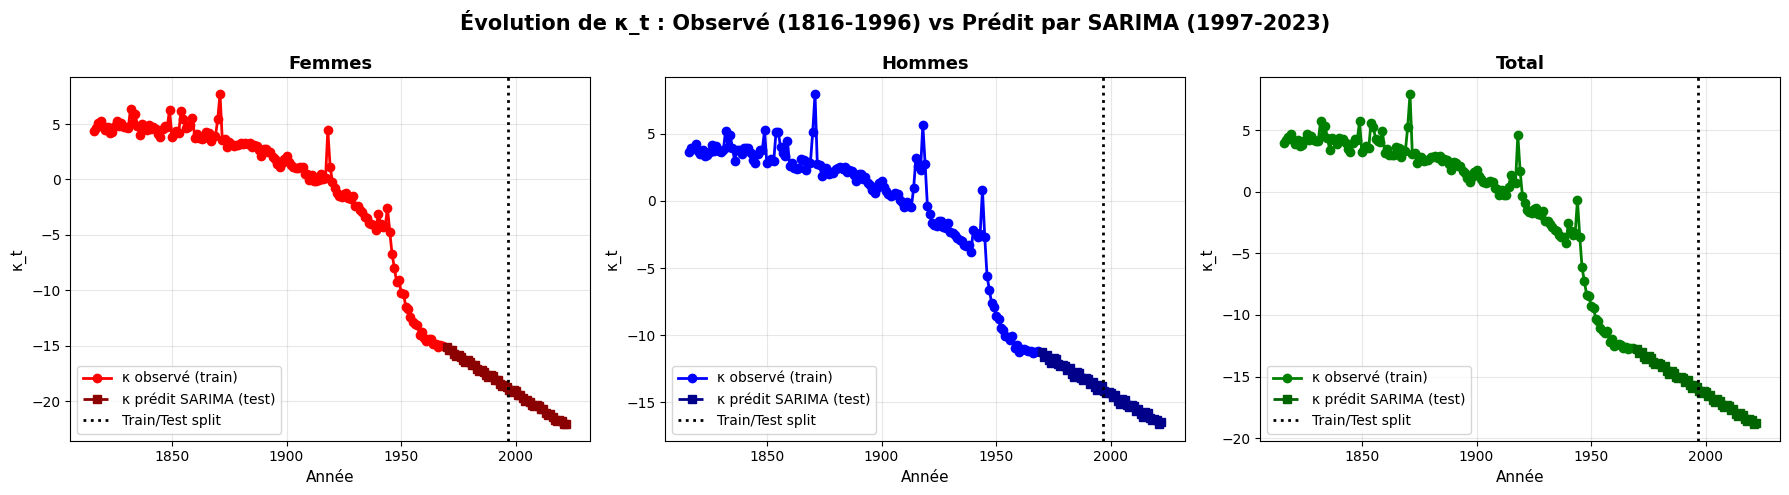

In [222]:
import matplotlib.pyplot as plt

# Graphique : on compare κ_t réel vs prédit
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Femmes
axes[0].plot(M_F_train.columns, kappa_F_train, 'o-', label='κ observé (train)', color='red', linewidth=2)
axes[0].plot(years_test, kappa_F_forecast, 's--', label='κ prédit SARIMA (test)', color='darkred', linewidth=2)
axes[0].axvline(x=1996.5, color='black', linestyle=':', linewidth=2, label='Train/Test split')
axes[0].set_xlabel('Année', fontsize=11)
axes[0].set_ylabel('κ_t', fontsize=11)
axes[0].set_title('Femmes', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Hommes
axes[1].plot(M_M_train.columns, kappa_M_train, 'o-', label='κ observé (train)', color='blue', linewidth=2)
axes[1].plot(years_test, kappa_M_forecast, 's--', label='κ prédit SARIMA (test)', color='darkblue', linewidth=2)
axes[1].axvline(x=1996.5, color='black', linestyle=':', linewidth=2, label='Train/Test split')
axes[1].set_xlabel('Année', fontsize=11)
axes[1].set_ylabel('κ_t', fontsize=11)
axes[1].set_title('Hommes', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Total
axes[2].plot(M_Tot_train.columns, kappa_Tot_train, 'o-', label='κ observé (train)', color='green', linewidth=2)
axes[2].plot(years_test, kappa_Tot_forecast, 's--', label='κ prédit SARIMA (test)', color='darkgreen', linewidth=2)
axes[2].axvline(x=1996.5, color='black', linestyle=':', linewidth=2, label='Train/Test split')
axes[2].set_xlabel('Année', fontsize=11)
axes[2].set_ylabel('κ_t', fontsize=11)
axes[2].set_title('Total', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Évolution de κ_t : Observé (1816-1996) vs Prédit par SARIMA (1997-2023)', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

#### C) Prédiction du taux de mortalité sur le set de test 1970-2023

Pour prédire 1997-2023, on a :
- alpha_x : vecteur de 99 valeurs (une par âge) - fixe, estimé sur 1816-1969
- beta_x : vecteur de 99 valeurs (une par âge) - fixe, estimé sur 1816-1969
- kappa_t : vecteur de 54 valeurs (une par année 1970-2023) - projeté par SARIMA

On utilise la formule ln(m_x,t) = alpha_x + (beta_x . kappa_t) pour avoir le taux de mortalité de Lee-Carter. 

In [223]:

# Création des matrices de test avec les vraies valeurs observées
M_F_test = dfm_test.pivot(index='Age', columns='Year', values='ln_m_F')
M_M_test = dfm_test.pivot(index='Age', columns='Year', values='ln_m_M')
M_Tot_test = dfm_test.pivot(index='Age', columns='Year', values='ln_m_Tot')

# Prédire ln(m) pour le test :

# Pour les Femmes
ln_m_pred_F_test = alpha_F_train.values[:, np.newaxis] + np.outer(beta_F_train, kappa_F_forecast) # on fait un produit extérieur
ln_m_pred_F_test = pd.DataFrame(ln_m_pred_F_test, index=M_F_test.index, columns=M_F_test.columns)

# Pour les Hommes
ln_m_pred_M_test = alpha_M_train.values[:, np.newaxis] + np.outer(beta_M_train, kappa_M_forecast)
ln_m_pred_M_test = pd.DataFrame(ln_m_pred_M_test, index=M_M_test.index, columns=M_M_test.columns)

# Pour le Total
ln_m_pred_Tot_test = alpha_Tot_train.values[:, np.newaxis] + np.outer(beta_Tot_train, kappa_Tot_forecast)
ln_m_pred_Tot_test = pd.DataFrame(ln_m_pred_Tot_test, index=M_Tot_test.index, columns=M_Tot_test.columns)


#### D) Calculs des erreurs entre les prédictions et les valeurs observés de la période de test (1970-2023)

Nous calculons les résidus en log : erreur = ln(m_obs) - ln(m_pred) = ln(m_obs/m_pred)

In [224]:
#Calcul des résidus du modèle 
residuals_F_test = M_F_test - ln_m_pred_F_test
residuals_M_test = M_M_test - ln_m_pred_M_test
residuals_Tot_test = M_Tot_test - ln_m_pred_Tot_test


#### D) Carte thermique des résidus par sexe 

On trace une carte thermique pour avoir une observation des erreurs selon le genre et les années. On remarque globalement que les résidus sont concentrés pour les jeunes entre 0 et 10 ans et sont négatifs. Elles sont aussi légèrement plus concentré pour les femmes que les hommes. Cela signifie qu'on surestime la mortalité (m_obs < m_pred donc ln(m_obs/m_pred) < 0). 
pour comprendre ces erreurs, on peut penser que la mortalité infantile a baissé plus vite que prévu par le modèle estimé sur 1816-1996 (progrès médicaux accélérés). Le modèle (basé sur le passé) est trop pessimiste. 

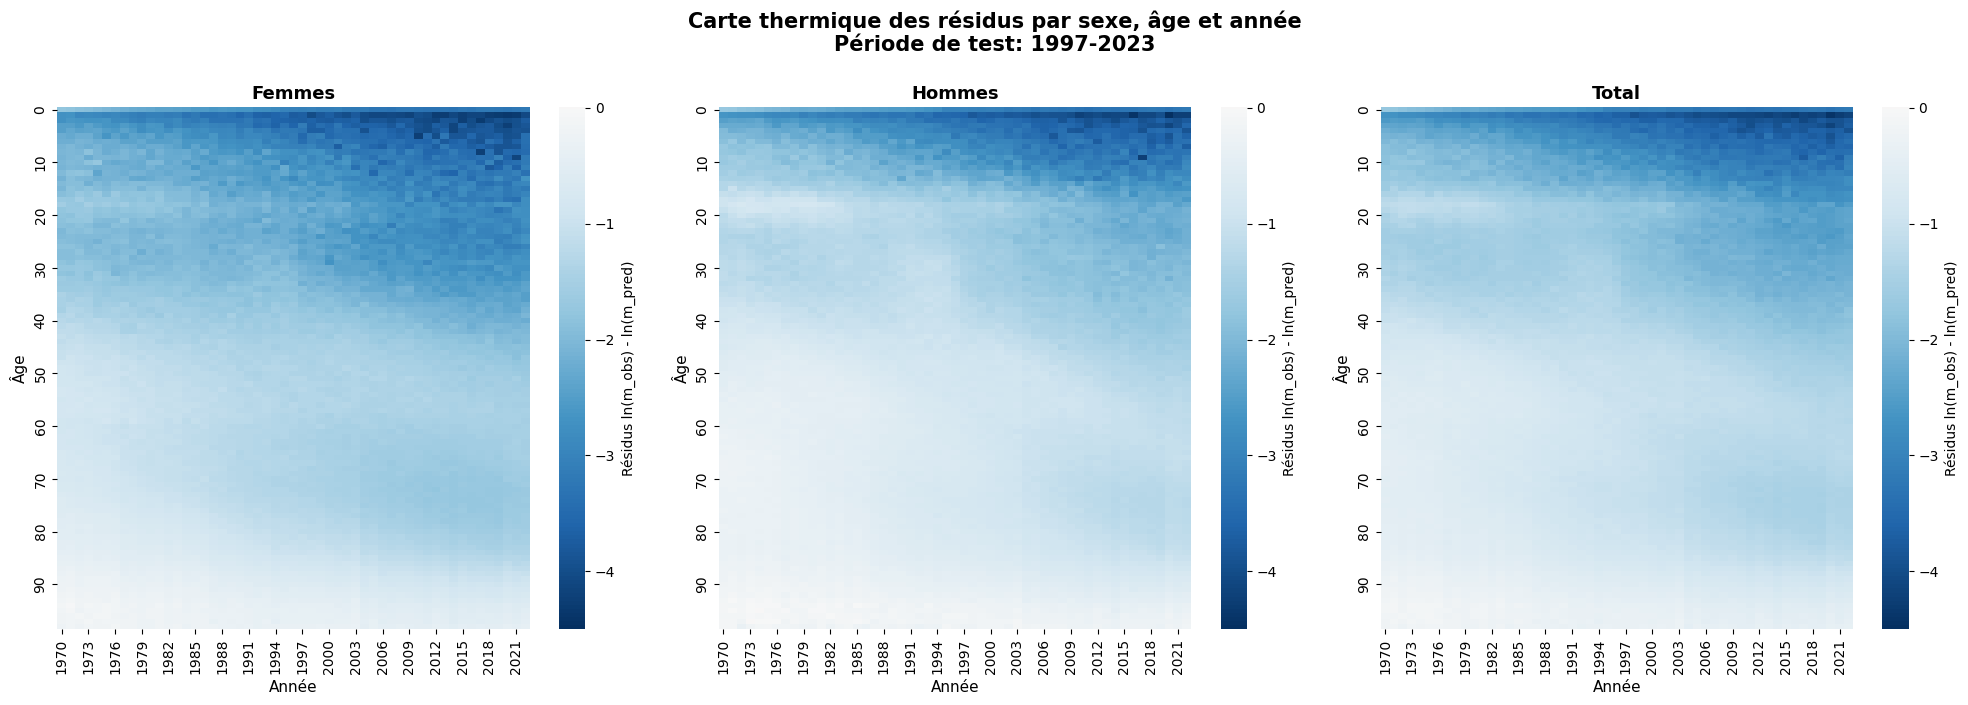

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

# Figure Carte thermique des résidus par sexe
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# On trouve le min/max commun pour la même échelle de couleur
vmin = min(residuals_F_test.min().min(), residuals_M_test.min().min(), residuals_Tot_test.min().min())
vmax = max(residuals_F_test.max().max(), residuals_M_test.max().max(), residuals_Tot_test.max().max())

# Carte thermique Femmes
sns.heatmap(residuals_F_test, cmap='RdBu_r', center=0, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Résidus ln(m_obs) - ln(m_pred)'}, ax=axes[0],
            xticklabels=3, yticklabels=10)
axes[0].set_xlabel('Année', fontsize=11)
axes[0].set_ylabel('Âge', fontsize=11)
axes[0].set_title('Femmes', fontsize=13, fontweight='bold')

# Carte thermique Hommes
sns.heatmap(residuals_M_test, cmap='RdBu_r', center=0, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Résidus ln(m_obs) - ln(m_pred)'}, ax=axes[1],
            xticklabels=3, yticklabels=10)
axes[1].set_xlabel('Année', fontsize=11)
axes[1].set_ylabel('Âge', fontsize=11)
axes[1].set_title('Hommes', fontsize=13, fontweight='bold')

# Carte thermique Total
sns.heatmap(residuals_Tot_test, cmap='RdBu_r', center=0, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Résidus ln(m_obs) - ln(m_pred)'}, ax=axes[2],
            xticklabels=3, yticklabels=10)
axes[2].set_xlabel('Année', fontsize=11)
axes[2].set_ylabel('Âge', fontsize=11)
axes[2].set_title('Total', fontsize=13, fontweight='bold')

plt.suptitle('Carte thermique des résidus par sexe, âge et année\nPériode de test: 1997-2023', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


Tracons les erreurs pour certains âges et vérifions qu'on prédit moins bien pour les jeunes que les vieux. On vérifie bien que le modèle surestime la mortalité pour tous les âges, d'autant plus pour les bas âges. 

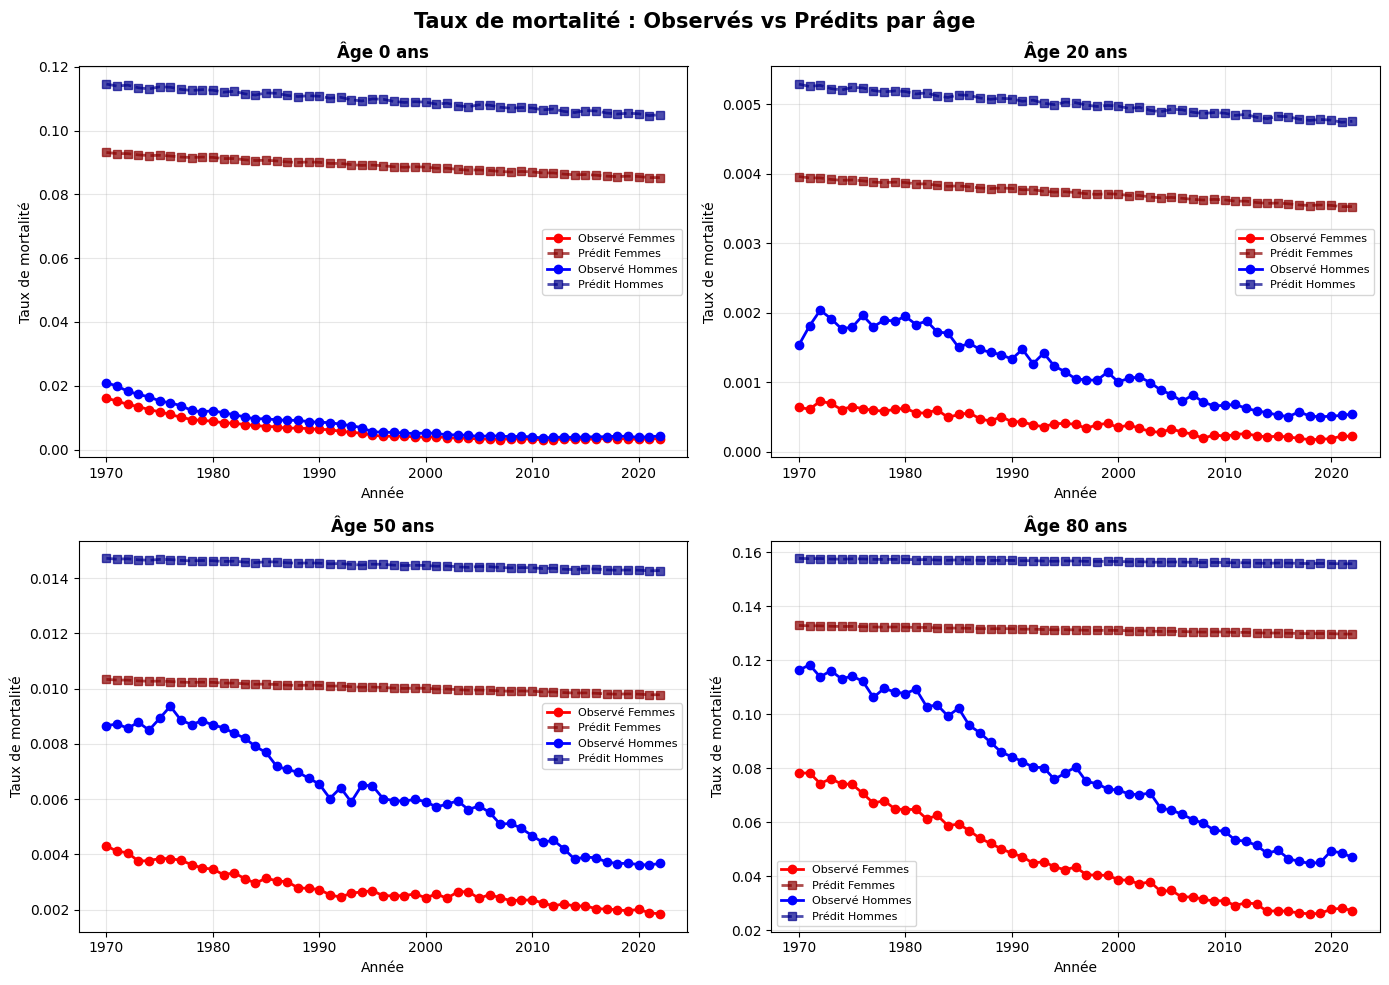

In [226]:
# Comparer obs vs pred pour quelques âges représentatifs
ages_to_plot = [0, 20, 50, 80]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, age in enumerate(ages_to_plot):
    ax = axes[i]
    
    # Femmes
    obs_F = np.exp(M_F_test.loc[age])
    pred_F = np.exp(ln_m_pred_F_test.loc[age])
    ax.plot(years_test, obs_F, 'o-', label='Observé Femmes', color='red', linewidth=2)
    ax.plot(years_test, pred_F, 's--', label='Prédit Femmes', color='darkred', linewidth=2, alpha=0.7)
    
    # Hommes
    obs_M = np.exp(M_M_test.loc[age])
    pred_M = np.exp(ln_m_pred_M_test.loc[age])
    ax.plot(years_test, obs_M, 'o-', label='Observé Hommes', color='blue', linewidth=2)
    ax.plot(years_test, pred_M, 's--', label='Prédit Hommes', color='darkblue', linewidth=2, alpha=0.7)
    
    ax.set_xlabel('Année', fontsize=10)
    ax.set_ylabel('Taux de mortalité', fontsize=10)
    ax.set_title(f'Âge {age} ans', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Taux de mortalité : Observés vs Prédits par âge', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

#### E) Autocorrélation (ACF) des résidus par sexe

L'autocorrélation mesure si les résidus d'une année sont corrélés avec les résidus des années précédentes. En clair : si le résidu en 2020 = +0.05 (on sous-estime), est-ce que le résidu en 2021 sera aussi positif ? (corrélation) Ou est-ce aléatoire ? (pas de corrélation). Le lag correspond au décalage. Par exemple, 
- Lag 1 : corrélation entre année t et année t-1 (1 an avant)
- Lag 2 : corrélation entre année t et année t-2 (2 ans avant)
- etc... 

Dans l'idéal, les erreurs sont aléatoires donc on aimerait avoir un ACF proche de 0 pour tous les lags (sauf lag 0 qui vaut toujours 1) et le modèle aura capturé toute l'info. Si ce n'est pas le cas, le modèle rate certainement une information comme une tendance ou un cycle. 

On fait aussi un test de Ljung-Box avec (H0 : pas d'autocorrélation). 

Résultats : pour tous les genres, la p-value est très proche de 0. On rejette H0, il y a une autocorrélation comme on peut l'observer sur le tracé de l'ACF en fonction du lag. 

Cela signifie que le modèle Lee-Carter ne capture pas entièrement les dynamiques temporelles de la mortalité.

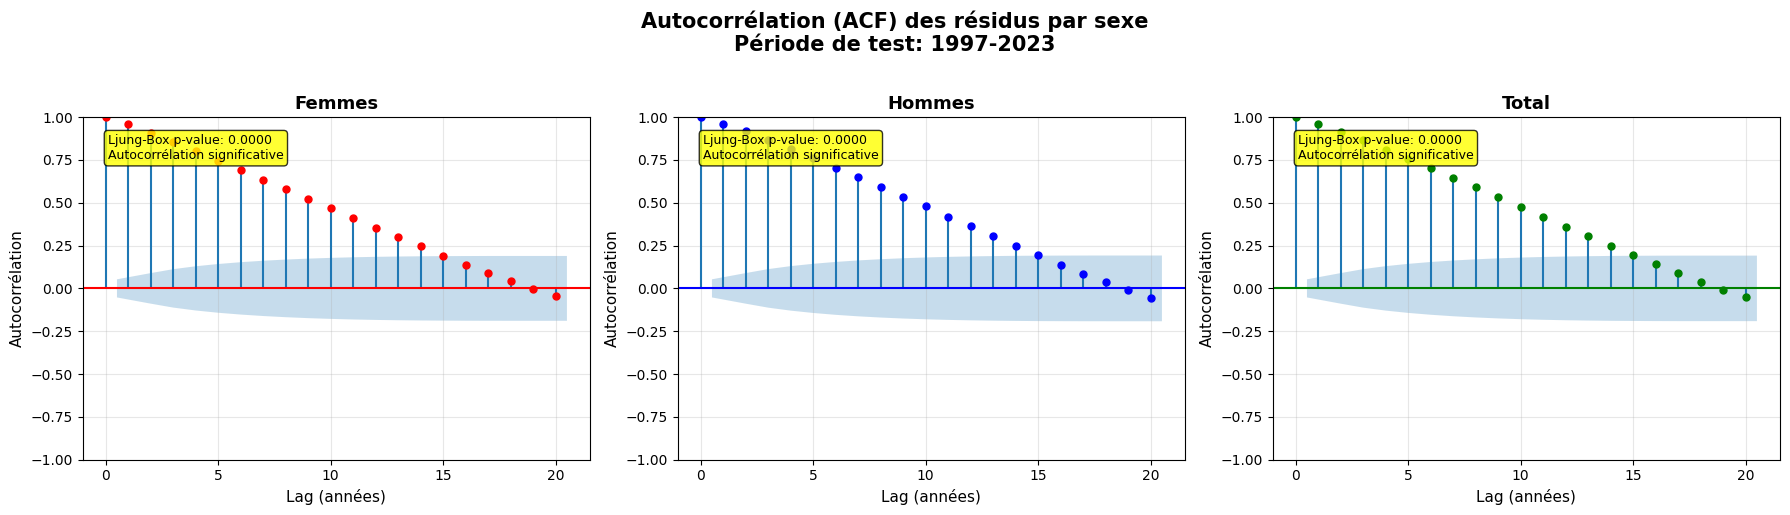

In [227]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import numpy as np

# Autocorrélation (ACF) des résidus par sexe
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# EXPLICATION : On calcule l'ACF sur les résidus MOYENS par année 
# car on veut voir si les erreurs d'une année influencent l'année suivante
# On moyenne sur tous les âges pour avoir 1 résidu par année


# Femmes - Résidus moyens par année (moyenne sur tous les âges)
residuals_F_by_year = residuals_F_test.mean(axis=0)  # 27 valeurs (1997-2023)

# Tracée de l'ACF
plot_acf(residuals_F_by_year, lags=20, ax=axes[0], color='red', alpha=0.7)
axes[0].set_title('Femmes', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Lag (années)', fontsize=11)
axes[0].set_ylabel('Autocorrélation', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Test de Ljung-Box (teste si l'autocorrélation est significative)
lb_F = acorr_ljungbox(residuals_F_by_year, lags=20, return_df=True)
pvalue_F = lb_F['lb_pvalue'].iloc[-1]  # p-value au lag 20

# on affiche la p-value sur le graphique
axes[0].text(0.05, 0.95, f'Ljung-Box p-value: {pvalue_F:.4f}\n' + 
             ('Autocorrélation significative' if pvalue_F < 0.05 else 'Pas d\'autocorrélation'),
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow' if pvalue_F < 0.05 else 'lightgreen', alpha=0.8),
             fontsize=9)

# Hommes
residuals_M_by_year = residuals_M_test.mean(axis=0)
plot_acf(residuals_M_by_year, lags=20, ax=axes[1], color='blue', alpha=0.7)
axes[1].set_title('Hommes', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Lag (années)', fontsize=11)
axes[1].set_ylabel('Autocorrélation', fontsize=11)
axes[1].grid(True, alpha=0.3)

lb_M = acorr_ljungbox(residuals_M_by_year, lags=20, return_df=True)
pvalue_M = lb_M['lb_pvalue'].iloc[-1]
axes[1].text(0.05, 0.95, f'Ljung-Box p-value: {pvalue_M:.4f}\n' +
             ('Autocorrélation significative' if pvalue_M < 0.05 else 'Pas d\'autocorrélation'),
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow' if pvalue_M < 0.05 else 'lightgreen', alpha=0.8),
             fontsize=9)

# Total
residuals_Tot_by_year = residuals_Tot_test.mean(axis=0)
plot_acf(residuals_Tot_by_year, lags=20, ax=axes[2], color='green', alpha=0.7)
axes[2].set_title('Total', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Lag (années)', fontsize=11)
axes[2].set_ylabel('Autocorrélation', fontsize=11)
axes[2].grid(True, alpha=0.3)

lb_Tot = acorr_ljungbox(residuals_Tot_by_year, lags=20, return_df=True)
pvalue_Tot = lb_Tot['lb_pvalue'].iloc[-1]
axes[2].text(0.05, 0.95, f'Ljung-Box p-value: {pvalue_Tot:.4f}\n' +
             ('Autocorrélation significative' if pvalue_Tot < 0.05 else 'Pas d\'autocorrélation'),
             transform=axes[2].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow' if pvalue_Tot < 0.05 else 'lightgreen', alpha=0.8),
             fontsize=9)

plt.suptitle('Autocorrélation (ACF) des résidus par sexe\nPériode de test: 1997-2023', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



#### F) QQ-plot des résidus

Le QQ-plot nous permet de comparer la distribution des résidus avec une distribution normale théorique.
Si les erreurs suivent une loi normale centrée, les intervalles de confiance sont valides, les tests statistiques fonctionnent bien. Sinon, les prédictions futures sont moins fiables et le modèle pourrait être amélioré. 

On remarque avec le tracé une déviation par rapport à la droite théorique. On réalise un test de Shapiro-Wild et on remarque que le test rejette la normalité pour tous les genres. 
Plusieurs causes possibles :
- Événements extrêmes (COVID, canicules, etc.)
- Asymétrie dans les erreurs (sous/sur-estimation systématique)
- Queues lourdes (plus d'outliers que prévu)


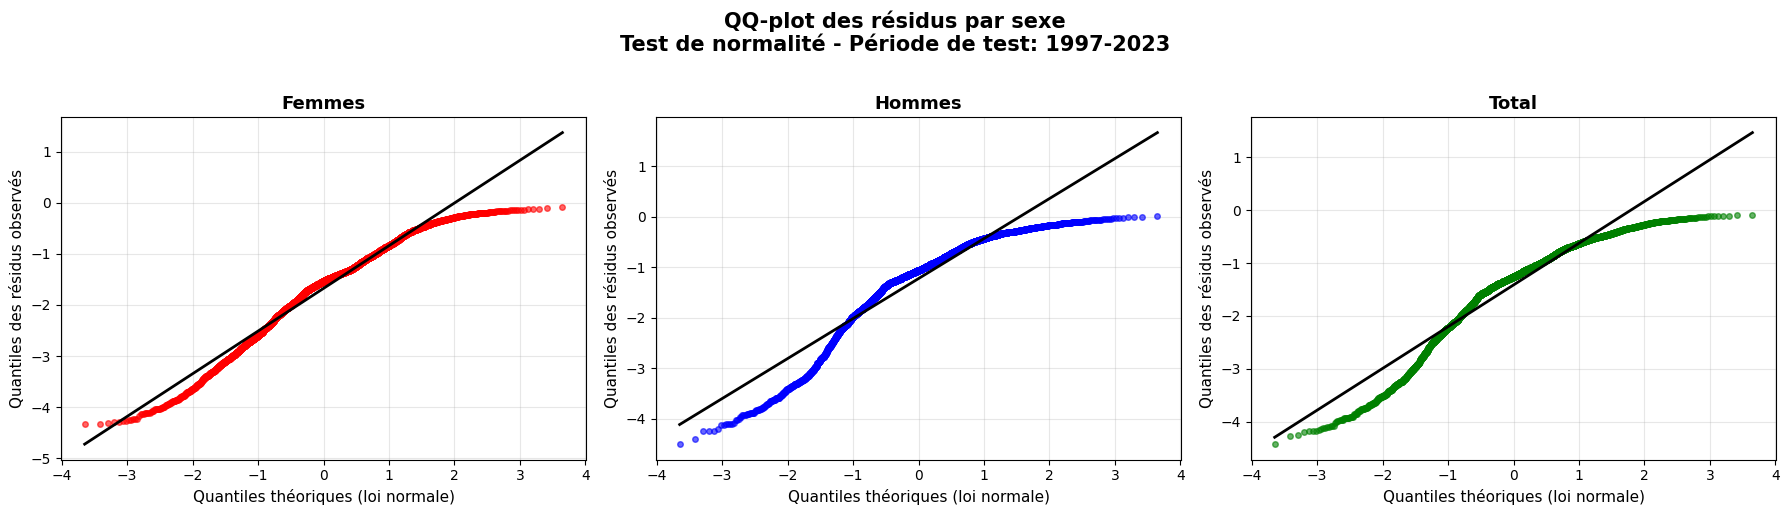

TESTS DE NORMALITÉ DES RÉSIDUS

FEMMES:
Test de Shapiro-Wilk:
   Statistique: 0.971876
   P-value: 0.000000
   → REJETTE normalité (p < 0.05)

HOMMES:
Test de Shapiro-Wilk:
   Statistique: 0.906048
   P-value: 0.000000
   → REJETTE normalité (p < 0.05)

TOTAL:
Test de Shapiro-Wilk:
   Statistique: 0.929702
   P-value: 0.000000
   → REJETTE normalité (p < 0.05)


np.float64(1.826336465994393e-43)

In [228]:

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro, jarque_bera, normaltest

# FiQQ-plot des résidus par sexe
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Préparation des résidus (on flatten et enlève les NaN)

# Femmes
residuals_F_flat = residuals_F_test.values.flatten()
residuals_F_flat = residuals_F_flat[~np.isnan(residuals_F_flat)]

# Hommes
residuals_M_flat = residuals_M_test.values.flatten()
residuals_M_flat = residuals_M_flat[~np.isnan(residuals_M_flat)]

# Total
residuals_Tot_flat = residuals_Tot_test.values.flatten()
residuals_Tot_flat = residuals_Tot_flat[~np.isnan(residuals_Tot_flat)]


# QQ-plots

# Femmes
stats.probplot(residuals_F_flat, dist="norm", plot=axes[0])
axes[0].get_lines()[0].set_markerfacecolor('red')
axes[0].get_lines()[0].set_markeredgecolor('red')
axes[0].get_lines()[0].set_markersize(4)
axes[0].get_lines()[0].set_alpha(0.6)
axes[0].get_lines()[1].set_color('black')
axes[0].get_lines()[1].set_linewidth(2)
axes[0].set_title('Femmes', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Quantiles théoriques (loi normale)', fontsize=11)
axes[0].set_ylabel('Quantiles des résidus observés', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Hommes
stats.probplot(residuals_M_flat, dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_markerfacecolor('blue')
axes[1].get_lines()[0].set_markeredgecolor('blue')
axes[1].get_lines()[0].set_markersize(4)
axes[1].get_lines()[0].set_alpha(0.6)
axes[1].get_lines()[1].set_color('black')
axes[1].get_lines()[1].set_linewidth(2)
axes[1].set_title('Hommes', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Quantiles théoriques (loi normale)', fontsize=11)
axes[1].set_ylabel('Quantiles des résidus observés', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Total
stats.probplot(residuals_Tot_flat, dist="norm", plot=axes[2])
axes[2].get_lines()[0].set_markerfacecolor('green')
axes[2].get_lines()[0].set_markeredgecolor('green')
axes[2].get_lines()[0].set_markersize(4)
axes[2].get_lines()[0].set_alpha(0.6)
axes[2].get_lines()[1].set_color('black')
axes[2].get_lines()[1].set_linewidth(2)
axes[2].set_title('Total', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Quantiles théoriques (loi normale)', fontsize=11)
axes[2].set_ylabel('Quantiles des résidus observés', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.suptitle('QQ-plot des résidus par sexe\nTest de normalité - Période de test: 1997-2023', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tests statistiques de normalité

print("TESTS DE NORMALITÉ DES RÉSIDUS")

def test_normalite(residuals, nom):
    """On effectue un test de shapirto-wilk"""
    print(f"\n{nom}:")
    
    # Test de Shapiro-Wilk 
    # Limite à 5000 observations
    sample_size = min(len(residuals), 5000)
    residuals_sample = np.random.choice(residuals, size=sample_size, replace=False)
    stat_shapiro, p_shapiro = shapiro(residuals_sample)
    print(f"Test de Shapiro-Wilk:")
    print(f"   Statistique: {stat_shapiro:.6f}")
    print(f"   P-value: {p_shapiro:.6f}")
    print(f"   → {'REJETTE normalité (p < 0.05)' if p_shapiro < 0.05 else 'ACCEPTE normalité (p > 0.05)'}")
    return p_shapiro

# Tester chaque population
test_normalite(residuals_F_flat, "FEMMES")
test_normalite(residuals_M_flat, "HOMMES")
test_normalite(residuals_Tot_flat, "TOTAL")



#### G) Calcul de métriques de performance

In [229]:
import pandas as pd
import numpy as np

# CALCUL DE TOUTES LES MÉTRIQUES DE PERFORMANCE

def calculate_all_metrics(obs, pred):
    """
    Calcule toutes les métriques de performance
    obs et pred sont en échelle LOG (ln(m))
    """
    # Erreurs en log
    errors_log = obs - pred
    
    # Métriques en log
    mae_log = np.mean(np.abs(errors_log))
    rmse_log = np.sqrt(np.mean(errors_log**2))
    
    # Revenir à l'échelle originale pour MAPE
    obs_orig = np.exp(obs)
    pred_orig = np.exp(pred)
    errors_orig = obs_orig - pred_orig
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs(errors_orig / obs_orig)) * 100
    
    # R² (coefficient de détermination)
    ss_res = np.sum(errors_log**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'MAE': mae_log,
        'RMSE': rmse_log,
        'MAPE (%)': mape,
        'R²': r2
    }

# Calculer pour chaque population (OUT-OF-SAMPLE)

metrics_F = calculate_all_metrics(
    M_F_test.values.flatten(), 
    ln_m_pred_F_test.values.flatten()
)

metrics_M = calculate_all_metrics(
    M_M_test.values.flatten(), 
    ln_m_pred_M_test.values.flatten()
)

metrics_Tot = calculate_all_metrics(
    M_Tot_test.values.flatten(), 
    ln_m_pred_Tot_test.values.flatten()
)

# CRÉATION DU TABLEAU

performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'RMSE', 'MAPE (%)', 'R²'],
    'Femmes': [
        f"{metrics_F['MAE']:.5f}",
        f"{metrics_F['RMSE']:.5f}",
        f"{metrics_F['MAPE (%)']:.1f}",
        f"{metrics_F['R²']:.4f}"
    ],
    'Hommes': [
        f"{metrics_M['MAE']:.5f}",
        f"{metrics_M['RMSE']:.5f}",
        f"{metrics_M['MAPE (%)']:.1f}",
        f"{metrics_M['R²']:.4f}"
    ],
    'Total': [
        f"{metrics_Tot['MAE']:.5f}",
        f"{metrics_Tot['RMSE']:.5f}",
        f"{metrics_Tot['MAPE (%)']:.1f}",
        f"{metrics_Tot['R²']:.4f}"
    ]
})


print("TABLE : ÉVALUATION NUMÉRIQUE DES PERFORMANCES")
print("Modèle Lee-Carter avec SARIMA - Période de test : 1997-2023")
print("="*70)
print(performance_df.to_string(index=False))
print("="*70)




TABLE : ÉVALUATION NUMÉRIQUE DES PERFORMANCES
Modèle Lee-Carter avec SARIMA - Période de test : 1997-2023
Métrique  Femmes  Hommes   Total
     MAE 1.67560 1.22412 1.41360
    RMSE 1.87714 1.47946 1.63343
MAPE (%)   701.7   439.7   529.1
      R²  0.3801  0.5920  0.4978


Conclusion : Avec les métriques de performances, le modèle est plus précis chez les hommes que chez les femmes (erreurs plus faibles). Le RMSE étant légèrement supérieur au MAE dans tous les cas, cela indique la présence de quelques erreurs plus importantes, mais pas de manière extrême. le MAPE a des valeurs anormalement élevées. Cela suggère fortement que certaines valeurs observées sont très proches de zéro (ou nulles), ce qui fait exploser la MAPE, même pour des erreurs absolues modestes. La MAPE n’est donc pas une métrique pertinente ici, et ne doit pas être utilisée pour juger la qualité du modèle dans ce contexte (mortalité/log-mortalité). En analysant le R2, Le Lee-Carter avec SARIMA capte une part substantielle de la dynamique, mais laisse une variabilité importante inexpliquée, surtout pour les femmes. 